In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# 1.1 Reading Data

In [4]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [5]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [7]:
project_data["teacher_prefix"].fillna(" ", inplace = True)

In [8]:
teacher_prefix = []

for i in range(len(project_data)):
    a = project_data["teacher_prefix"][i].replace('.',' ')
    teacher_prefix.append(a)

In [9]:
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

In [10]:
project_data["teacher_prefix"] =teacher_prefix

In [11]:
project_data.head(5)

Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           CA   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           GA   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           WA   

                     Date project_grade_category project_subject_categories  \
55660 2016-04-27 00:27:36          Grades PreK-2             Math & Science   
76127 2016-04-27 00:31:25             Grades 3-5              Special Needs   
51140 2016-04-27 00:46:53          Grades PreK-2        Literacy & Language   
473   2016-04-27 00:53:00          Grades PreK-2           Applied Learning   
41558 2016-04-27 01:05:25             Grades 3-5        Literacy & Language   

                 project_subject_subcategories  \
55660  Applied Sciences, Health & Life Science   
76127                            Special Needs   
51140                                 Literacy   
473                          Early Development   
41558                                 Literacy   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   
473            Flexible Seating for Flexible Learning   
41558          Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

      teacher_prefix  
55660           Mrs   
76127            Mr   
51140            Ms   
473             Mrs   
41558           Mrs

In [12]:
project_grade_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-","_")
    project_grade_category.append(a)

In [13]:
project_data.drop(['project_grade_category'], axis=1, inplace=True)

In [14]:
project_data["project_grade_category"] = project_grade_category

In [15]:
project_data.head(5)

Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           CA   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           GA   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           WA   

                     Date project_subject_categories  \
55660 2016-04-27 00:27:36             Math & Science   
76127 2016-04-27 00:31:25              Special Needs   
51140 2016-04-27 00:46:53        Literacy & Language   
473   2016-04-27 00:53:00           Applied Learning   
41558 2016-04-27 01:05:25        Literacy & Language   

                 project_subject_subcategories  \
55660  Applied Sciences, Health & Life Science   
76127                            Special Needs   
51140                                 Literacy   
473                          Early Development   
41558                                 Literacy   

                                        project_title  \
55660    Engineering STEAM into the Primary Classroom   
76127                         Sensory Tools for Focus   
51140  Mobile Learning with a Mobile Listening Center   
473            Flexible Seating for Flexible Learning   
41558          Going Deep: The Art of Inner Thinking!   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   
51140  Having a class of 24 students comes with diver...   
473    I recently read an article about giving studen...   
41558  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

      teacher_prefix project_grade_category  
55660           Mrs           Grades_PreK_2  
76127            Mr              Grades_6_8  
51140            Ms              Grades_6_8  
473             Mrs           Grades_PreK_2  
41558           Mrs           Grades_PreK_2

# 1.2 Preprocessing of project_subject_categories¶

In [16]:
catogories = list(project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

# 1.3 Preprocessing of project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

# 1.4 Clean Titles (Text preprocessing)

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
clean_titles = []

for titles in tqdm(project_data["project_title"]):
    title = decontracted(titles)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = title.replace('\\n', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    title = ' '.join(f for f in title.split() if f not in stopwords)
    clean_titles.append(title.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:03<00:00, 30841.29it/s]


In [21]:
project_data["clean_titles"] = clean_titles

In [22]:
project_data.drop(['project_title'], axis=1, inplace=True)

Number of Words in Title

In [23]:
title_word_count = []

In [24]:
for a in project_data["clean_titles"] :
    b = len(a.split())
    title_word_count.append(b)

In [25]:
project_data["title_word_count"] = title_word_count

In [26]:
project_data.head(5)

Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           CA   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           GA   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           WA   

                     Date                                    project_essay_1  \
55660 2016-04-27 00:27:36  I have been fortunate enough to use the Fairy ...   
76127 2016-04-27 00:31:25  Imagine being 8-9 years old. You're in your th...   
51140 2016-04-27 00:46:53  Having a class of 24 students comes with diver...   
473   2016-04-27 00:53:00  I recently read an article about giving studen...   
41558 2016-04-27 01:05:25  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

      teacher_prefix project_grade_category   clean_categories  \
55660           Mrs           Grades_PreK_2       Math_Science   
76127            Mr              Grades_6_8       SpecialNeeds   
51140            Ms              Grades_6_8  Literacy_Language   
473             Mrs           Grades_PreK_2    AppliedLearning   
41558           Mrs           Grades_PreK_2  Literacy_Language   

                      clean_subcategories  \
55660  AppliedSciences Health_LifeScience   
76127                        SpecialNeeds   
51140                            Literacy   
473                      EarlyDevelopment   
41558                            Literacy   

                                  clean_titles  title_word_count  
55660      engineering steam primary classroom                 4  
76127                      sensory tools focus                 3  
51140  mobile learning mobile listening center                 5  
473         flexible seating flexible learning                 4  
41558        going deep the art inner thinking                 6

# 1.6 Combine 4 Project essays into 1 Essay

In [27]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 1.7 Clean Essays (Text preprocessing)

In [28]:
clean_essay = []

for ess in tqdm(project_data["essay"]):
    ess = decontracted(ess)
    ess = ess.replace('\\r', ' ')
    ess = ess.replace('\\"', ' ')
    ess = ess.replace('\\n', ' ')
    ess = re.sub('[^A-Za-z0-9]+', ' ', ess)
    ess = ' '.join(f for f in ess.split() if f not in stopwords)
    clean_essay.append(ess.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:13<00:00, 1496.29it/s]


In [29]:
project_data["clean_essays"] = clean_essay

In [30]:
project_data.drop(['essay'], axis=1, inplace=True)

Number of Words in Essay

In [31]:
essay_word_count = []

In [32]:
for ess in project_data["clean_essays"] :
    c = len(ess.split())
    essay_word_count.append(c)

In [33]:
project_data["essay_word_count"] = essay_word_count

In [34]:
project_data.head(5)

Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           CA   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           GA   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           WA   

                     Date                                    project_essay_1  \
55660 2016-04-27 00:27:36  I have been fortunate enough to use the Fairy ...   
76127 2016-04-27 00:31:25  Imagine being 8-9 years old. You're in your th...   
51140 2016-04-27 00:46:53  Having a class of 24 students comes with diver...   
473   2016-04-27 00:53:00  I recently read an article about giving studen...   
41558 2016-04-27 01:05:25  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   
51140  My students need a mobile listening center to ...   
473    My students need flexible seating in the class...   
41558  My students need copies of the New York Times ...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   
76127                                             4                    1   
51140                                            10                    1   
473                                               2                    1   
41558                                             2                    1   

      teacher_prefix project_grade_category   clean_categories  \
55660           Mrs           Grades_PreK_2       Math_Science   
76127            Mr              Grades_6_8       SpecialNeeds   
51140            Ms              Grades_6_8  Literacy_Language   
473             Mrs           Grades_PreK_2    AppliedLearning   
41558           Mrs           Grades_PreK_2  Literacy_Language   

                      clean_subcategories  \
55660  AppliedSciences Health_LifeScience   
76127                        SpecialNeeds   
51140                            Literacy   
473                      EarlyDevelopment   
41558                            Literacy   

                                  clean_titles  title_word_count  \
55660      engineering steam primary classroom                 4   
76127                      sensory tools focus                 3   
51140  mobile learning mobile listening center                 5   
473         flexible seating flexible learning                 4   
41558        going deep the art inner thinking                 6   

                                            clean_essays  essay_word_count  
55660  i

# 1.9 Calculate Sentiment Scores for the essays

In [35]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [36]:
analyser = SentimentIntensityAnalyzer()

In [37]:
neg = []
pos = []
neu = []
compound = []

for a in tqdm(project_data["clean_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [16:50<00:00, 108.15it/s]


In [38]:
project_data["pos"] = pos

In [39]:
project_data["neg"] = neg

In [40]:
project_data["neu"] = neu

In [41]:
project_data["compound"] = compound

In [42]:
project_data.head(5)

Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   
51140       74477  p189804  4a97f3a390bfe21b99cf5e2b81981c73           CA   
473        100660  p234804  cbc0e38f522143b86d372f8b43d4cff3           GA   
41558       33679  p137682  06f6e62e17de34fcf81020c77549e1d5           WA   

                     Date                                    project_essay_1  \
55660 2016-04-27 00:27:36  I have been fortunate enough to use the Fairy ...   
76127 2016-04-27 00:31:25  Imagine being 8-9 years old. You're in your th...   
51140 2016-04-27 00:46:53  Having a class of 24 students comes with diver...   
473   2016-04-27 00:53:00  I recently read an article about giving studen...   
41558 2016-04-27 01:05:25  My students crave challenge, they eat obstacle...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   
51140  I have a class of twenty-four kindergarten stu...   
473    I teach at a low-income (Title 1) school. Ever...   
41558  We are an urban, public k-5 elementary school....   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   
51140  By having a mobile listening and storage cente...   
473    We need a classroom rug that we can use as a c...   
41558  With the new common core standards that have b...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   
51140  A mobile listening center will help keep equip...   
473    Benjamin Franklin once said, \"Tell me and I f...   
41558  These remarkable gifts will provide students w...   

                                project_resource_summary    ...     \
55660  My students need STEM kits to learn critical s...    ...      
76127  My students need Boogie Boards for quiet senso...    ...      
51140  My students need a mobile listening center to ...    ...      
473    My students need flexible seating in the class...    ...      
41558  My students need copies of the New York Times ...    ...      

        clean_categories                 clean_subcategories  \
55660       Math_Science  AppliedSciences Health_LifeScience   
76127       SpecialNeeds                        SpecialNeeds   
51140  Literacy_Language                            Literacy   
473      AppliedLearning                    EarlyDevelopment   
41558  Literacy_Language                            Literacy   

                                  clean_titles title_word_count  \
55660      engineering steam primary classroom                4   
76127                      sensory tools focus                3   
51140  mobile learning mobile listening center                5   
473         flexible seating flexible learning                4   
41558        going deep the art inner thinking                6   

                                            clean_essays essay_word_count  \
55660  i fortunate enough use fairy tale stem kits cl...              175   
76127  imagine 8 9 years old you third grade classroo...              179   
51140  having class 24 students comes diverse learner...              116   
473    i recently read article giving students choice...              127   
41558  my students crave challenge eat obstacles brea...              114   

         pos    neg    neu  compound  
55660  0.205  0.013  0.783    0.9867  
76127  0.248  0.072  0.680    0.9897  
51140  0.262  0.017  0.721    0.9860  
473    0.187  0.030  0.783    0.9524  
41558  0.288  0.029  0.683    0.9873  

[5 rows x 24 columns]

# 1.10 Test - Train Split

In [43]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])


In [44]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)


# Preparing data for models

In [45]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state', 'Date',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'teacher_prefix', 'project_grade_category', 'clean_categories',
       'clean_subcategories', 'clean_titles', 'title_word_count',
       'clean_essays', 'essay_word_count', 'pos', 'neg', 'neu', 'compound'],
      dtype='object')

we are going to consider

   - school_state : categorical data
   - clean_categories : categorical data
   - clean_subcategories : categorical data
   - project_grade_category : categorical data
   - teacher_prefix : categorical data

   - project_title : text data
   - text : text data
   - project_resource_summary: text data (optional)

   - quantity : numerical (optional)
   - teacher_number_of_previously_posted_projects : numerical
   - price : numerical
   - title_word_count : numerical
   - essay_word_count : numerical
   - essay sentiment [positive] : numerical
   - essay sentiment [negative] : numerical
   - essay sentiment [neutral] : numerical
   - essay sentiment [compound] : numerical

# 2.1 Vectorizing Categorical data

# One Hot Encode - Clean Categories of Projects

In [46]:
# we use count vectorizer to convert the values into one 

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_proj = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_proj.fit(X_train['clean_categories'].values)

categories_one_hot_train = vectorizer_proj.transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer_proj.transform(X_test['clean_categories'].values)

print(vectorizer_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",categories_one_hot_test.shape)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix of Train data after one hot encoding  (73196, 9)
Shape of matrix of Test data after one hot encoding  (36052, 9)


# One Hot Encode - Clean Sub-Categories of Projects¶

In [47]:
# we use count vectorizer to convert the values into one 

vectorizer_sub_proj = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_proj.fit(X_train['clean_subcategories'].values)

sub_categories_one_hot_train = vectorizer_sub_proj.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer_sub_proj.transform(X_test['clean_subcategories'].values)


print(vectorizer_sub_proj.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",sub_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",sub_categories_one_hot_test.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix of Train data after one hot encoding  (73196, 30)
Shape of matrix of Test data after one hot encoding  (36052, 30)


# One Hot Encode - School States

In [48]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [49]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [50]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer_states = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_states.fit(X_train['school_state'].values)

school_state_categories_one_hot_train = vectorizer_states.transform(X_train['school_state'].values)
school_state_categories_one_hot_test = vectorizer_states.transform(X_test['school_state'].values)

print(vectorizer_states.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",school_state_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",school_state_categories_one_hot_test.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix of Train data after one hot encoding  (73196, 51)
Shape of matrix of Test data after one hot encoding  (36052, 51)


# One Hot Encode - Project Grade Category

In [51]:
my_counter = Counter()
for project_grade in project_data['project_grade_category'].values:
    my_counter.update(project_grade.split())

In [52]:
project_grade_cat_dict = dict(my_counter)
sorted_project_grade_cat_dict = dict(sorted(project_grade_cat_dict.items(), key=lambda kv: kv[1]))

In [53]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer_grade = CountVectorizer(vocabulary=list(sorted_project_grade_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'].values)

project_grade_categories_one_hot_train = vectorizer_grade.transform(X_train['project_grade_category'].values)
project_grade_categories_one_hot_test = vectorizer_grade.transform(X_test['project_grade_category'].values)

print(vectorizer_grade.get_feature_names())

print("Shape of matrix of Train data after one hot encoding ",project_grade_categories_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",project_grade_categories_one_hot_test.shape)

['Grades_9_12', 'Grades_6_8', 'Grades_3_5', 'Grades_PreK_2']
Shape of matrix of Train data after one hot encoding  (73196, 4)
Shape of matrix of Test data after one hot encoding  (36052, 4)


# One Hot Encode - Teacher Prefix

In [54]:
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [55]:
teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))

In [56]:
vectorizer_teacher = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values.astype("U"))

teacher_prefix_categories_one_hot_train = vectorizer_teacher.transform(X_train['teacher_prefix'].values.astype("U"))
teacher_prefix_categories_one_hot_test = vectorizer_teacher.transform(X_test['teacher_prefix'].values.astype("U"))

print(vectorizer_teacher.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_test.shape)

['Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']
Shape of matrix after one hot encoding  (73196, 5)
Shape of matrix after one hot encoding  (36052, 5)


# 2.2 Vectorizing Text data

# A) Bag of Words (BOW) with bi-grams with min_df=10 

# Bag of words - Train Data - Essays¶

In [57]:
vectorizer_bow_essay = CountVectorizer(ngram_range=(2,2), min_df=10)

vectorizer_bow_essay.fit(X_train["clean_essays"])

text_bow_train = vectorizer_bow_essay.transform(X_train["clean_essays"])

print("Shape of matrix after one hot encoding ",text_bow_train.shape)

Shape of matrix after one hot encoding  (73196, 132675)


# Bag of words - Test Data - Essays

In [58]:
text_bow_test = vectorizer_bow_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 132675)


# Bag of words - Train Data - Titles

In [59]:
vectorizer_bow_title = CountVectorizer(ngram_range=(2,2), min_df=10)

vectorizer_bow_title.fit(X_train["clean_titles"])

title_bow_train = vectorizer_bow_title.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_train.shape)

Shape of matrix after one hot encoding  (73196, 2667)


# Bag of words - Test Data - Titles

In [60]:
title_bow_test = vectorizer_bow_title.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_bow_test.shape)

Shape of matrix after one hot encoding  (36052, 2667)


# B) TFIDF vectorizer with bi-grams with min_df=10
TFIDF - Train Data - Essays

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf_essay = TfidfVectorizer(ngram_range=(2,2), min_df=10)
vectorizer_tfidf_essay.fit(X_train["clean_essays"])

text_tfidf_train = vectorizer_tfidf_essay.transform(X_train["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (73196, 132675)


# TFIDF - Test Data - Essays

In [62]:
text_tfidf_test = vectorizer_tfidf_essay.transform(X_test["clean_essays"])
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 132675)


# TFIDF - Train Data - Titles

In [63]:
vectorizer_tfidf_titles = TfidfVectorizer(ngram_range=(2,2), min_df=10)

vectorizer_tfidf_titles.fit(X_train["clean_titles"])
title_tfidf_train = vectorizer_tfidf_titles.transform(X_train["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_train.shape)

Shape of matrix after one hot encoding  (73196, 2667)


# TFIDF - Test Data - Titles

In [64]:
title_tfidf_test = vectorizer_tfidf_titles.transform(X_test["clean_titles"])
print("Shape of matrix after one hot encoding ",title_tfidf_test.shape)

Shape of matrix after one hot encoding  (36052, 2667)


# C) Using Pretrained Models : AVG W2V

In [65]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [66]:
words_train_essays = []

for i in X_train["clean_essays"] :
    words_train_essays.extend(i.split(' '))

In [67]:
## Find the total number of words in the Train data of Essays.

print("all the words in the corpus", len(words_train_essays))

all the words in the corpus 11086932


In [68]:
## Find the unique words in this set of words

words_train_essay = set(words_train_essays)
print("the unique words in the corpus", len(words_train_essay))

the unique words in the corpus 48346


In [69]:
# Find the words present in both Glove Vectors as well as our corpus.

inter_words = set(model.keys()).intersection(words_train_essay)

print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_train_essay))*100)))

The number of words that are present in both glove vectors and our corpus are 43499 which is nearly 90.0% 


In [70]:
words_corpus_train_essay = {}

words_glove = set(model.keys())

for i in words_train_essay:
    if i in words_glove:
        words_corpus_train_essay[i] = model[i]

print("word 2 vec length", len(words_corpus_train_essay))

word 2 vec length 43499


# Train - Essays

In [71]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_train = []; 

for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 73196/73196 [00:28<00:00, 2587.88it/s]


73196
300


# Test - Essays

In [72]:
# average Word2Vec
# compute average word2vec for each review.

avg_w2v_vectors_test = []; 

for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:13<00:00, 2598.44it/s]


36052
300


# Train - Titles

In [73]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_train.append(vector)

print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 73196/73196 [00:01<00:00, 52419.45it/s]


73196
300


# Test - Titles

In [74]:
# Similarly you can vectorize for title also

avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_titles"]): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_test.append(vector)

print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 47920.27it/s]


36052
300


# D) Using Pretrained Models: TFIDF weighted W2V
Train - Essays

In [75]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_essays"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [76]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [03:11<00:00, 381.86it/s]


73196
300


# Test - Essays

In [77]:
# compute average word2vec for each review.

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:47<00:00, 264.43it/s]


36052
300


# Train - Titles

In [78]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_titles"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [79]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_train = []; 

for sentence in tqdm(X_train["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_train.append(vector)

print(len(tfidf_w2v_vectors_titles_train))
print(len(tfidf_w2v_vectors_titles_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 73196/73196 [00:03<00:00, 20079.85it/s]


73196
300


# Test - Titles

In [80]:
# compute average word2vec for each review.

tfidf_w2v_vectors_titles_test = []; 

for sentence in tqdm(X_test["clean_titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles_test.append(vector)

print(len(tfidf_w2v_vectors_titles_test))
print(len(tfidf_w2v_vectors_titles_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:02<00:00, 17842.29it/s]


36052
300


# 2.3 Vectorizing Numerical features

In [81]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [82]:
# join two dataframes in python: 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')

# A) Price

In [83]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# B) Quantity

In [84]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape)
print(quantity_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# C) Number of Projects previously proposed by Teacher

In [85]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(prev_projects_train.shape, y_train.shape)
print(prev_projects_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# D) Title word Count

In [86]:
normalizer = Normalizer()

normalizer.fit(X_train['title_word_count'].values.reshape(-1,1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(title_word_count_train.shape, y_train.shape)
print(title_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# E) Essay word Count

In [87]:
normalizer = Normalizer()

normalizer.fit(X_train['essay_word_count'].values.reshape(-1,1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(essay_word_count_train.shape, y_train.shape)
print(essay_word_count_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# F) Essay Sentiments - pos

In [88]:
normalizer = Normalizer()

normalizer.fit(X_train['pos'].values.reshape(-1,1))

essay_sent_pos_train = normalizer.transform(X_train['pos'].values.reshape(-1,1))
essay_sent_pos_test = normalizer.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_pos_train.shape, y_train.shape)
print(essay_sent_pos_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# G) Essay Sentiments - neg

In [89]:
normalizer = Normalizer()

normalizer.fit(X_train['neg'].values.reshape(-1,1))

essay_sent_neg_train = normalizer.transform(X_train['neg'].values.reshape(-1,1))
essay_sent_neg_test = normalizer.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neg_train.shape, y_train.shape)
print(essay_sent_neg_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# H) Essay Sentiments - neu

In [90]:
normalizer = Normalizer()

normalizer.fit(X_train['neu'].values.reshape(-1,1))

essay_sent_neu_train = normalizer.transform(X_train['neu'].values.reshape(-1,1))
essay_sent_neu_test = normalizer.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_neu_train.shape, y_train.shape)
print(essay_sent_neu_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# I) Essay Sentiments - compound

In [91]:
normalizer = Normalizer()

normalizer.fit(X_train['compound'].values.reshape(-1,1))

essay_sent_comp_train = normalizer.transform(X_train['compound'].values.reshape(-1,1))
essay_sent_comp_test = normalizer.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(essay_sent_comp_train.shape, y_train.shape)
print(essay_sent_comp_test.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# Assignment 7: SVM

1. [Task-1] Apply Support Vector Machines(SGDClassifier with hinge loss: Linear SVM) on these feature sets
    : categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)
    : categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)
    : categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)
    : categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

2.The hyper paramter tuning (best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')
    Find the best hyper parameter which will give the maximum AUC value
    Find the best hyper paramter using k-fold cross validation or simple cross validation data
    Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning

3.Representation of results
   * You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown      in the figure. 
   * Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot      the ROC curve on both train and test. 
   * Along with plotting ROC curve, you need to print the confusion matrix with predicted and original labels of test data            points. Please visualize your confusion matrices using seaborn heatmaps. 

 4.[Task-2] Apply the Support Vector Machines on these features by finding the best hyper paramter as suggested in step 2 and      step 3
Consider these set of features
        school_state : categorical data
        clean_categories : categorical data
        clean_subcategories : categorical data
        project_grade_category :categorical data
        teacher_prefix : categorical data
        quantity : numerical data
        teacher_number_of_previously_posted_projects : numerical data
        price : numerical data
        sentiment score's of each of the essay : numerical data
        number of words in the title : numerical data
        number of words in the combine essays : numerical data
        Apply TruncatedSVD on TfidfVectorizer of essay text, choose the number of components (`n_components`) using elbow               method : numerical data


Conclusion:

        You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table             please refer to this prettytable library link 

    * There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
    * To avoid the issue of data-leakage, make sure to split your data first and then vectorize it.
    * While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on             cv/test data.
    * For more details please go through this link.

# Support Vector Machines

# Set 1: Categorical, Numerical features + Project_title(BOW) + Preprocessed_essay (BOW with min_df=10)

In [92]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_comp_train, title_bow_train, text_bow_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_comp_test, title_bow_test, text_bow_test)).tocsr()

In [93]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 135450) (73196,)
(36052, 135450) (36052,)


# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l2)

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

In [95]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

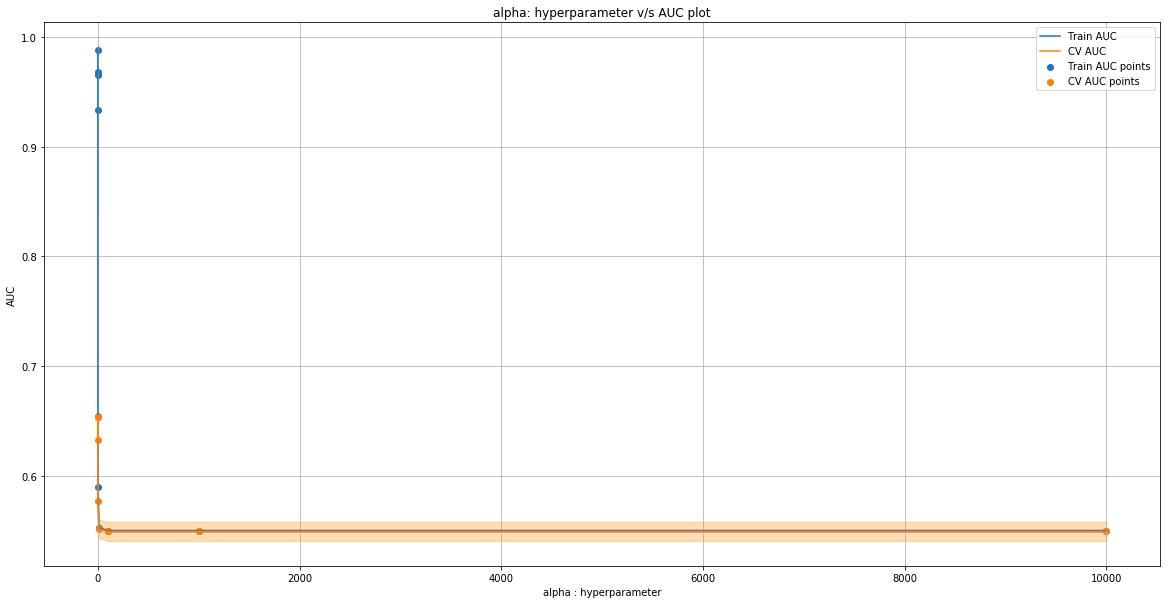

In [96]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

Inference:
we are not able to deteremine the appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.

In [97]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

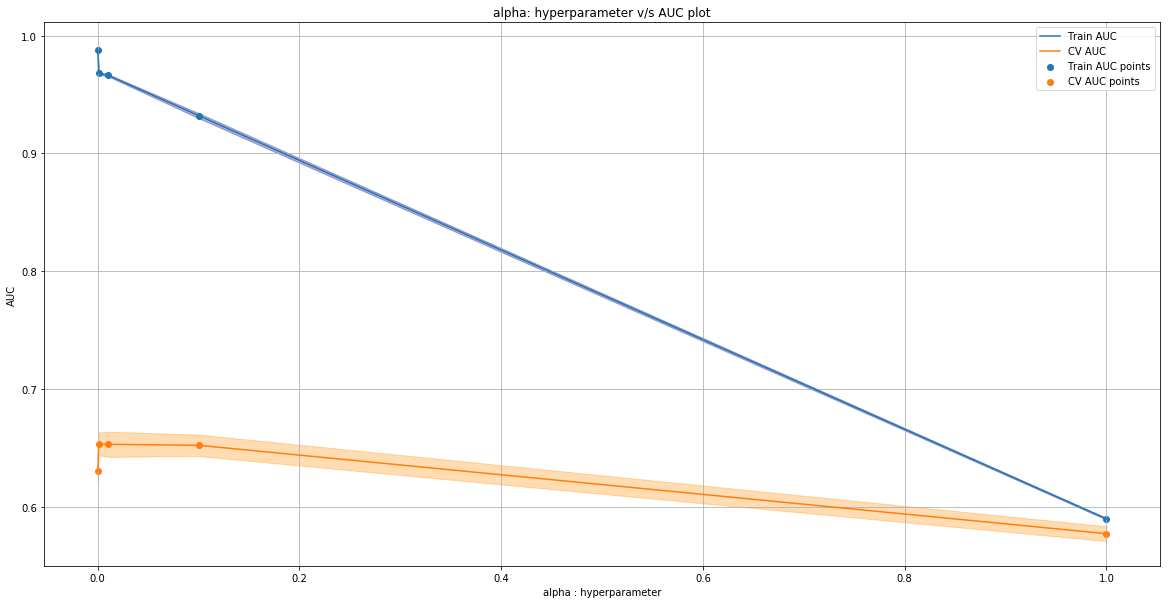

In [98]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of      parameter values.
2. I was able to narrow down to a range of alpha values that might lead to expected result.

In [99]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

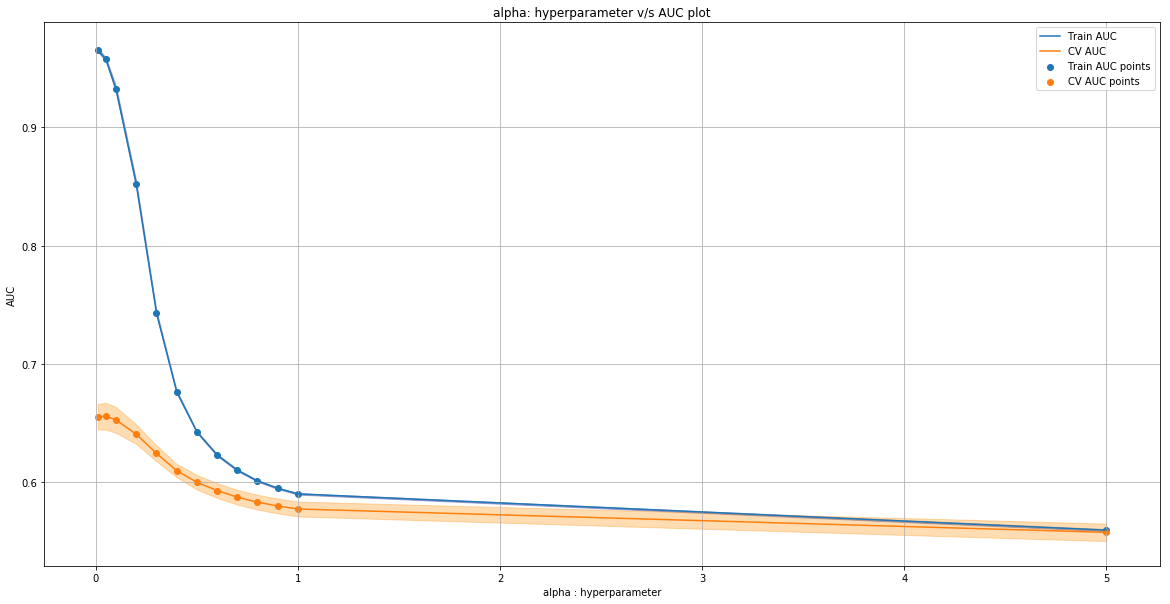

In [100]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

Inference
1) 0.3 is chosen as the best hyperparameter value.
2) The AUC values for the parameters/points after 0.1 are lower. While for 0.1 there is a major difference between the Train and the Test model. So, 0.3 is considered.

# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l1)

In [101]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

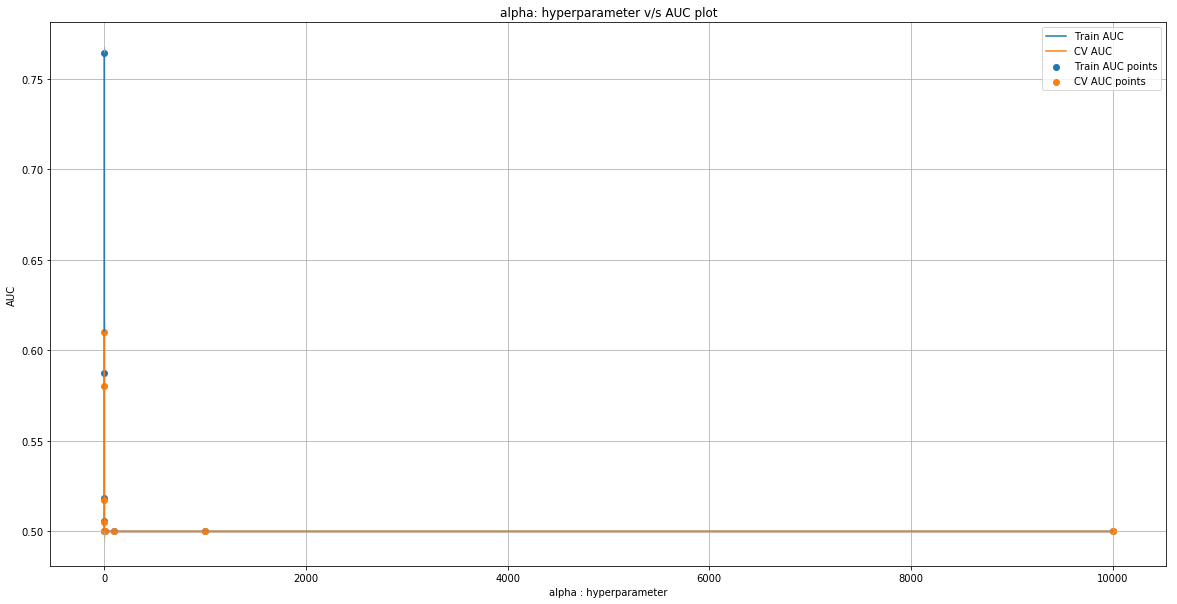

In [102]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

Inference:
    re-running on a smaller set of parameter values

In [103]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

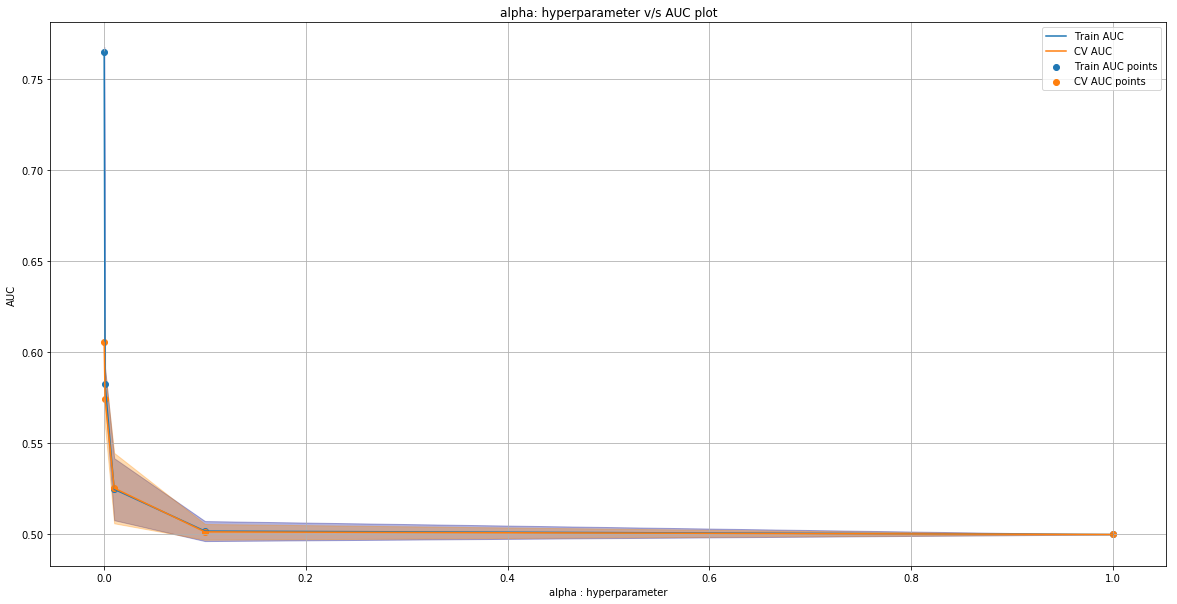

In [104]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

In [105]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

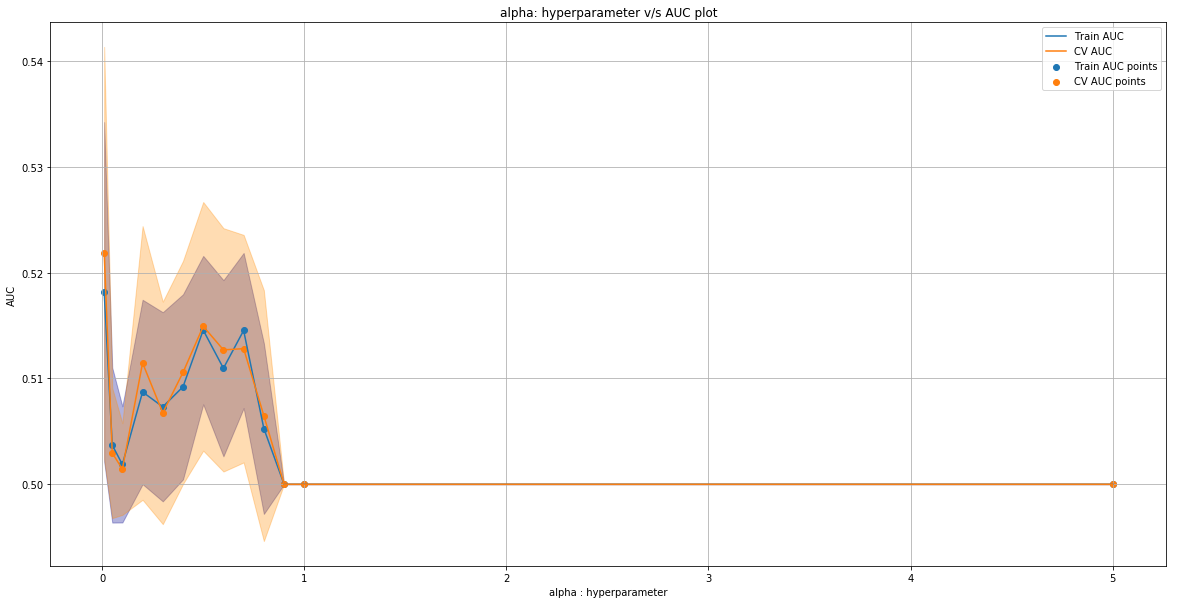

In [106]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.grid()
plt.show()

Inference
1. I was not able to deteremine the appropriate value for my parameter.
2. L1 regularization yields a comparitively lower AUC score and the range seems to be more thicker, making it difficult to choose an appropriate value.

# Train the model using the best hyper parameter value

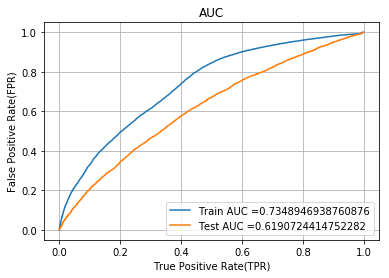

In [107]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.3)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# Confusion Matrix

In [108]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Train Data

In [109]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.0
[[ 5542  5541]
 [ 9631 52482]]


In [110]:
conf_matr_df_train_1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.0


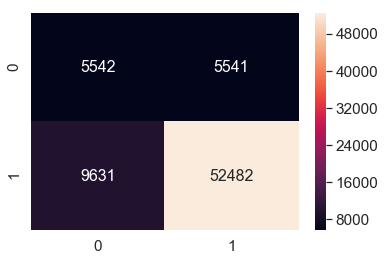

In [111]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_1, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [112]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 1.009
[[ 3999  1460]
 [17494 13099]]


In [113]:
conf_matr_df_test_1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092995 for threshold 1.009


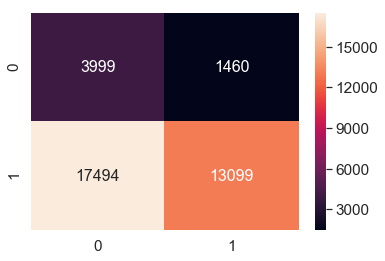

In [114]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_1, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 2 : Categorical, Numerical features + Project_title(TFIDF) + Preprocessed_essay (TFIDF min_df=10)

In [115]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_comp_train, title_tfidf_train, text_tfidf_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_comp_test, title_tfidf_test, text_tfidf_test)).tocsr()

In [116]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 135450) (73196,)
(36052, 135450) (36052,)


# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l2)

In [117]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

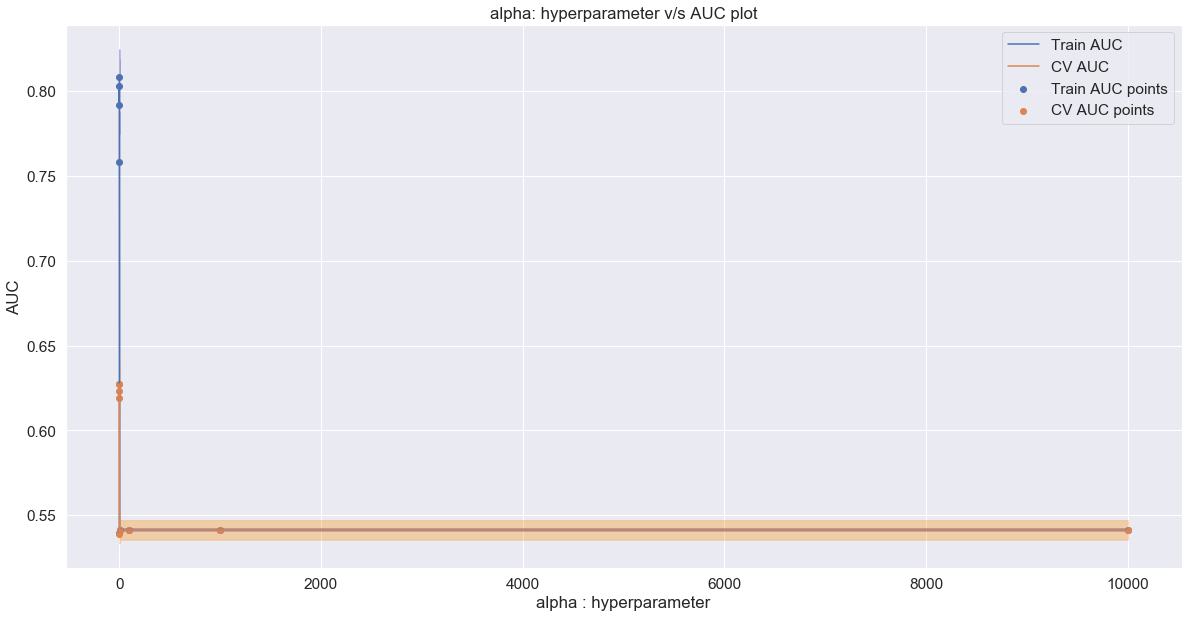

In [118]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference:
    appropriate value for parameter is not able to determine so we run on smaller set of parameter values.

In [119]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

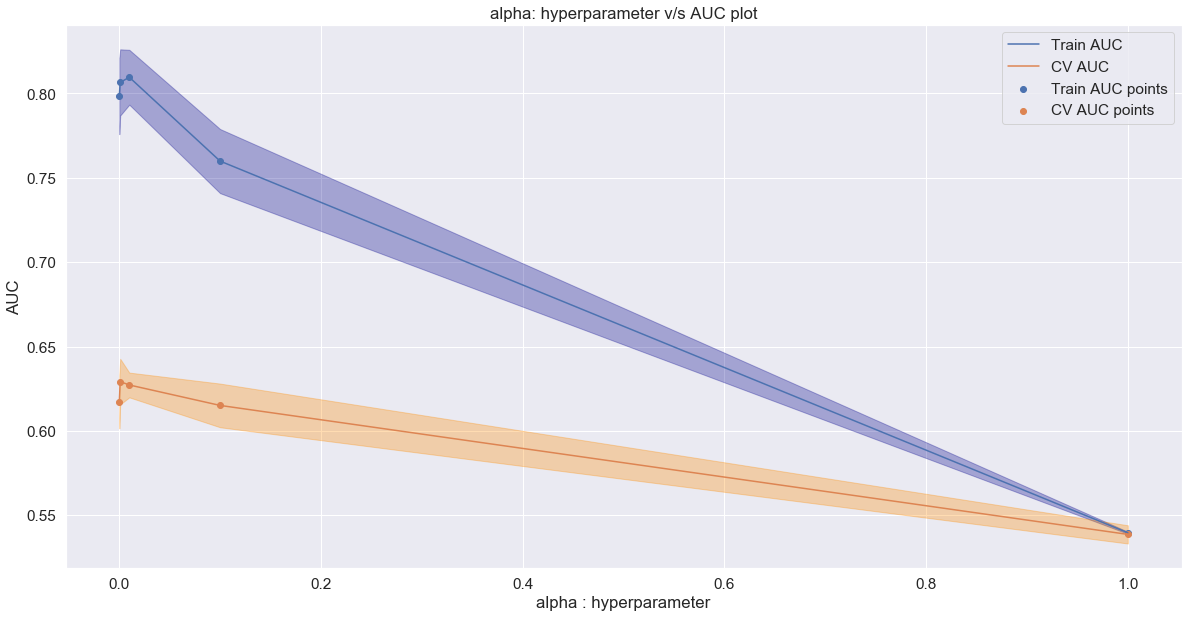

In [120]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()


In [121]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

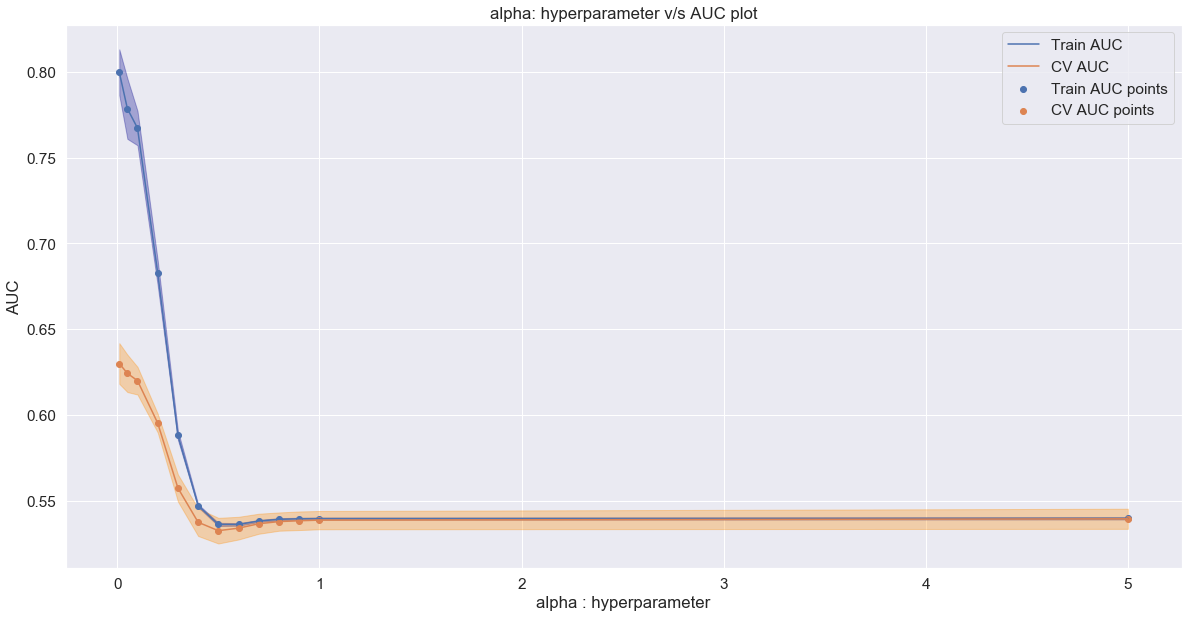

In [122]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()


Inference
1) The AUC values for the parameters after 0.1 are to be lower. While for 0.1 there to be a major difference between the Train and the Test model.
2) Points below 0.2 had a lower AUC score, almost closer to 0.55

# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l1)

In [123]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

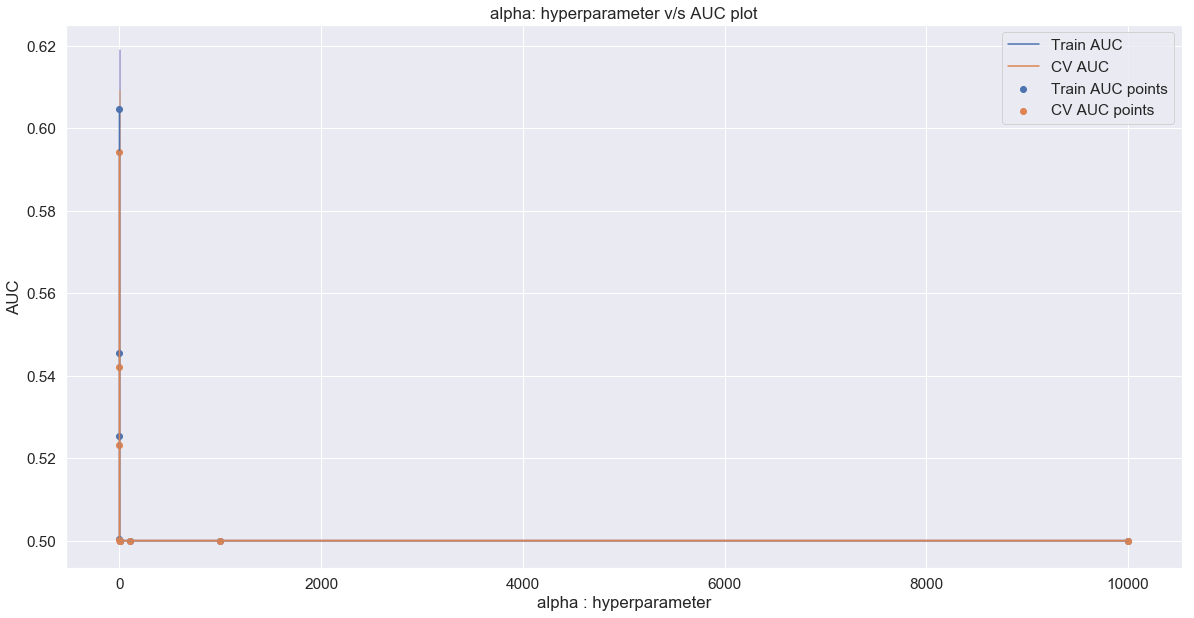

In [124]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference:
   Appropriate value is not determined so, i re-run with some small sets of paramters

In [125]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

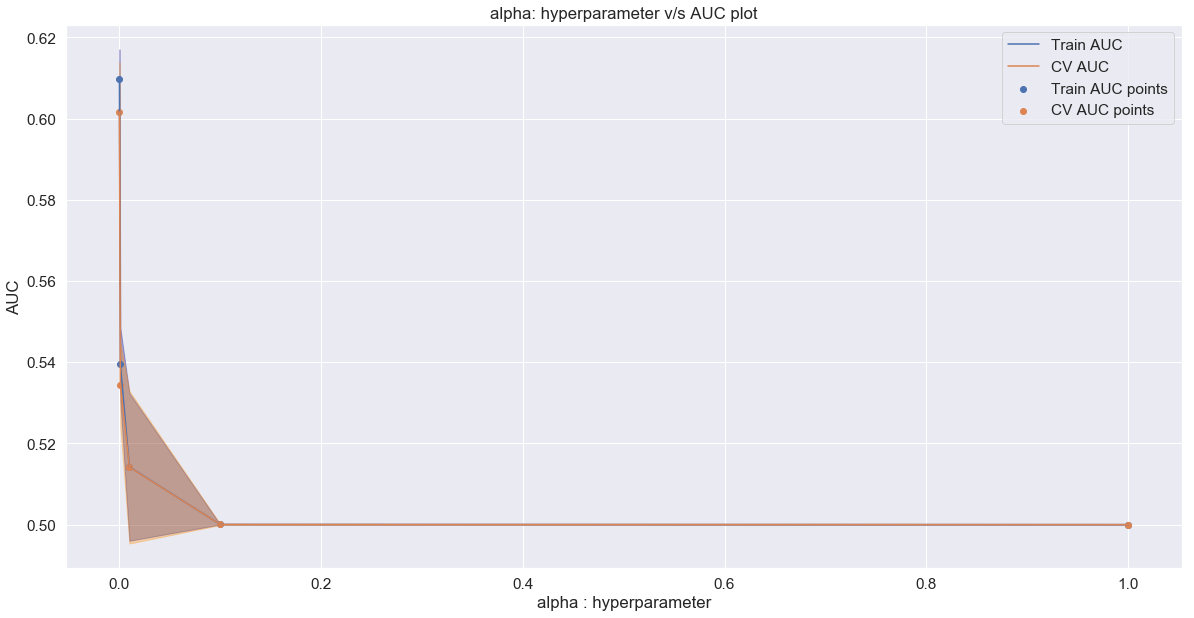

In [126]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

In [127]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[0.00001,0.00005,0.0001, 0.0005, 0.0001, 0.0002, 0.0003]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

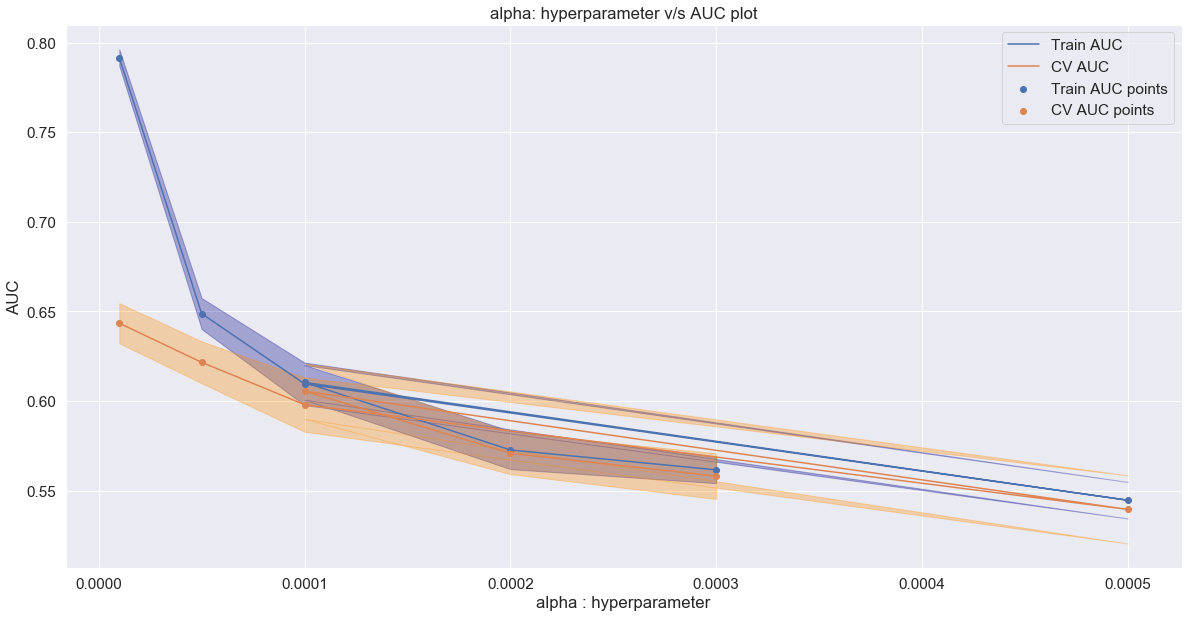

In [128]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1) 0.0001 was chosen as an appropriate value for my parameter.
2) L1 Regularization seems to yield better parameter value when compared to L2 Regularization.
3) AUC scores are low for the points after 0.0001.
4) The difference between the train and test model is high for the values less than 0.0001

# Train the model using the best hyper parameter value

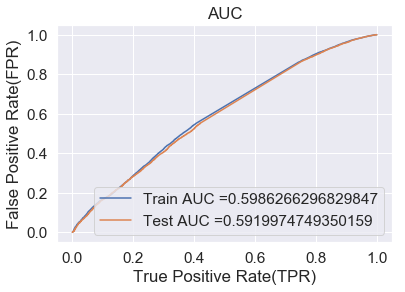

In [129]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

# Confusion Matrix

In [130]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2412368237956204 for threshold 1.073
[[ 6579  4504]
 [27866 34247]]


In [131]:
conf_matr_df_train_2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2412368237956204 for threshold 1.073


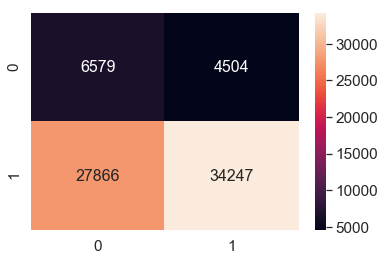

In [132]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_2, annot=True,annot_kws={"size": 16}, fmt='g')

Test Data

In [133]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24378100621257612 for threshold 1.11
[[ 4186  1273]
 [20735  9858]]


In [134]:
conf_matr_df_test_2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24378100621257612 for threshold 1.11


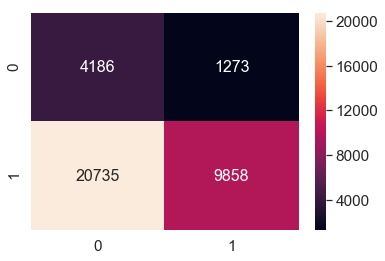

In [135]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_2, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 3 : Categorical, Numerical features + Project_title(AVG W2V) + Preprocessed_essay (AVG W2V)

In [136]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_comp_train, avg_w2v_vectors_train, avg_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_comp_test, avg_w2v_vectors_test, avg_w2v_vectors_titles_test)).tocsr()

In [137]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 708) (73196,)
(36052, 708) (36052,)


# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l2)

In [138]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

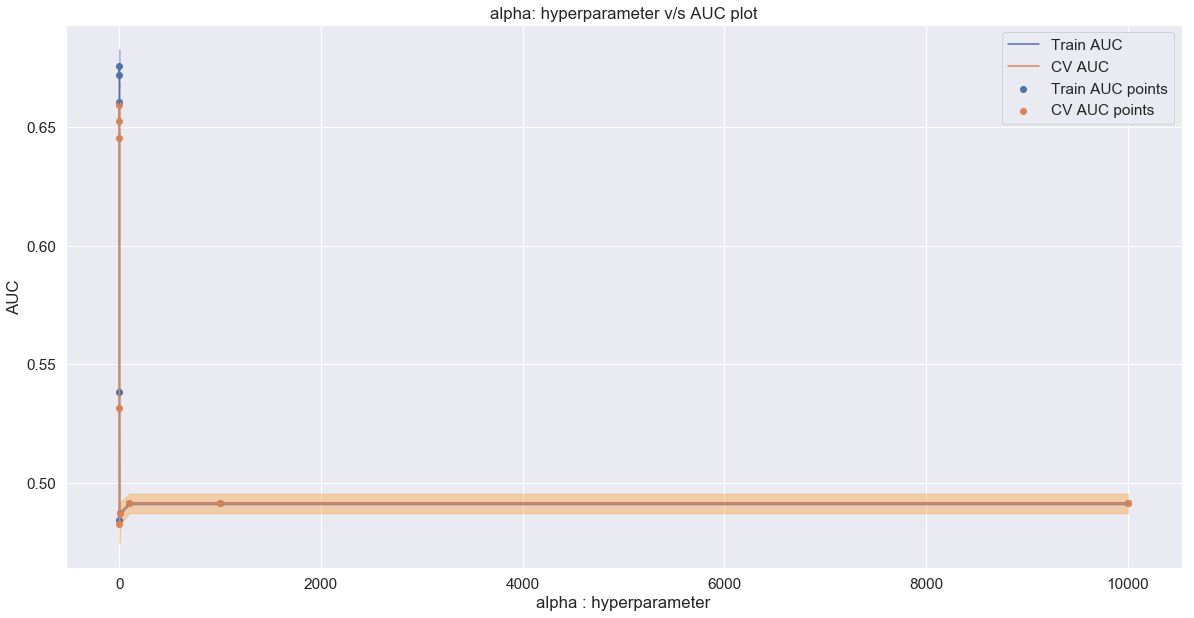

In [139]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.
3. Values in the range of 10^-4, 10^-3 & 10^-2 had considerable amount of difference in the AUC scores of Train and Cross Validation data.
4. Values in the range of 10^-2 to 10^-1 have a better chance of being the appropriate hyperparameter value. While the values more than 10^-1 has a pretty low AUC score.
5. So, I shall consider values in the range of 10^-3 to 10^-1

In [140]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

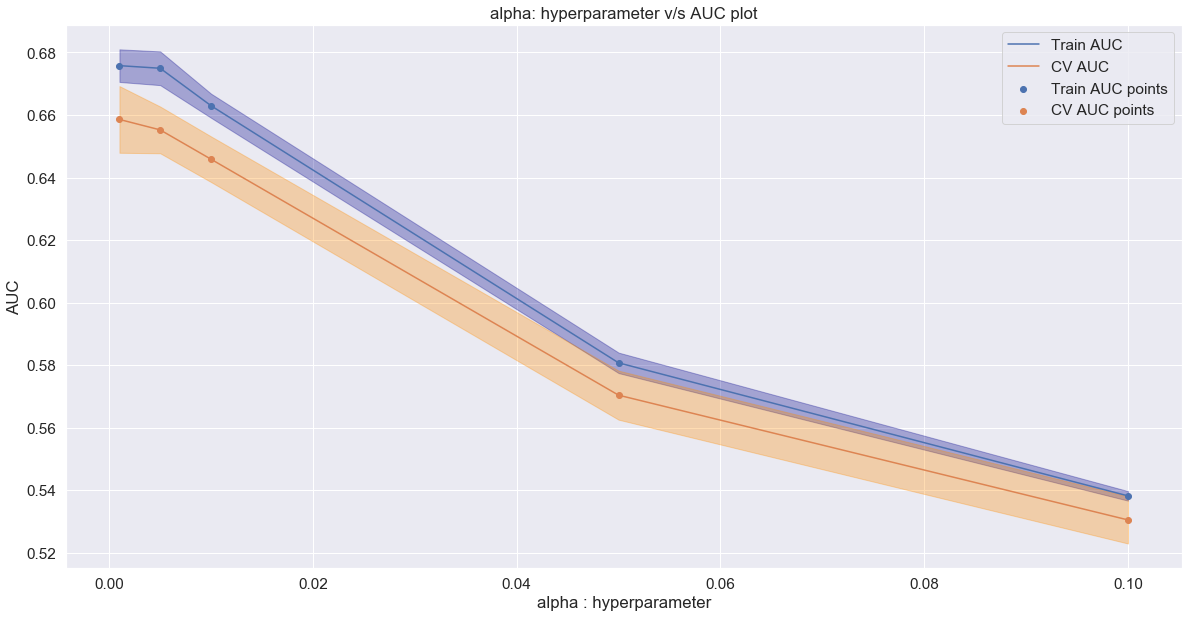

In [141]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1) 0.005 is considered as the best value, because the points after and before have a lesser AUC score.
2) Also the difference between the Train and Cross Validation data is similar, the model tends to perform better and similar.

# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l1)

In [142]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

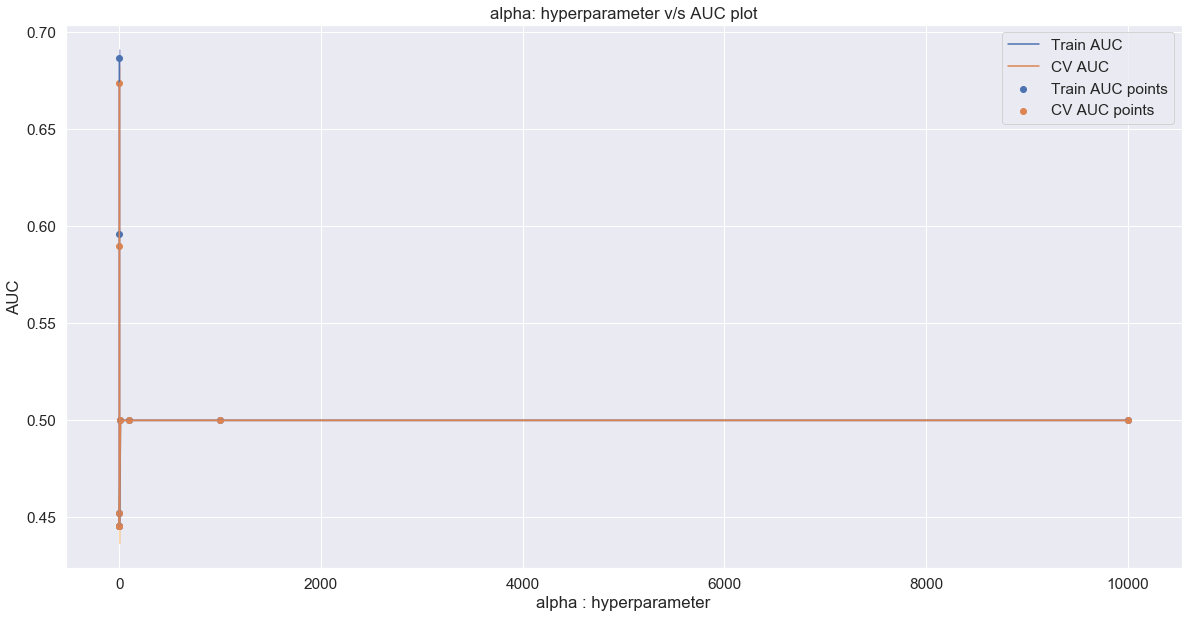

In [143]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.
3. Values in the range of 10^-4 to 10^-3 as alpha value have a better AUC score as well as lesser difference in AUC values.

In [144]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

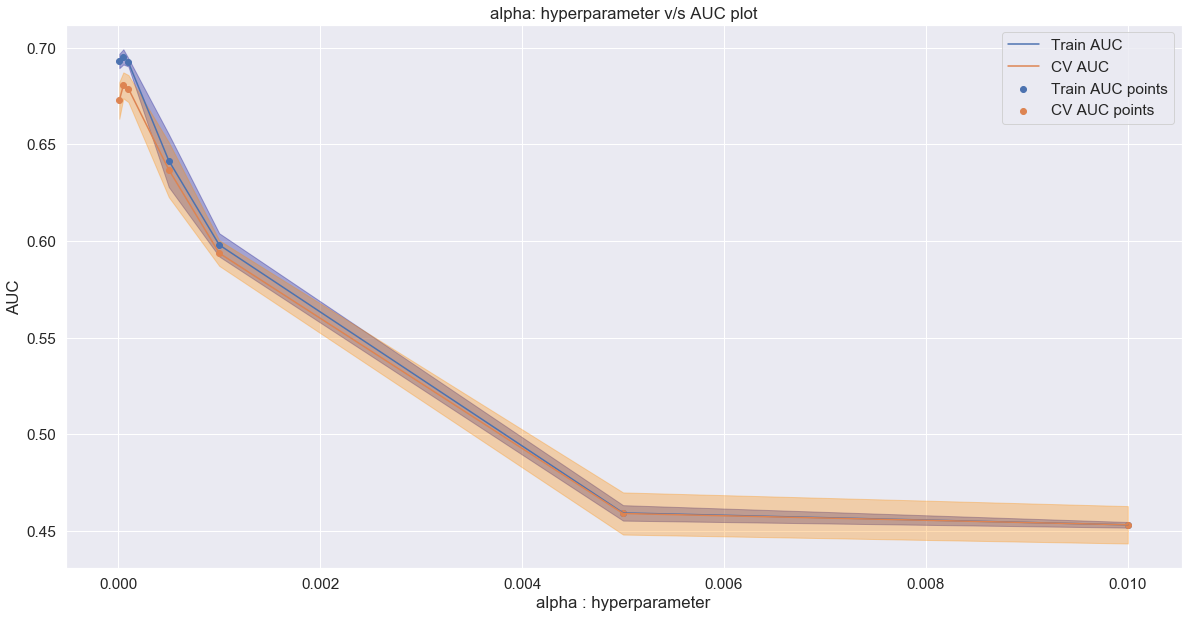

In [145]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.

In [146]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[0.00001, 0.00003, 0.00007, 0.00009, 0.00011, 0.00014]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

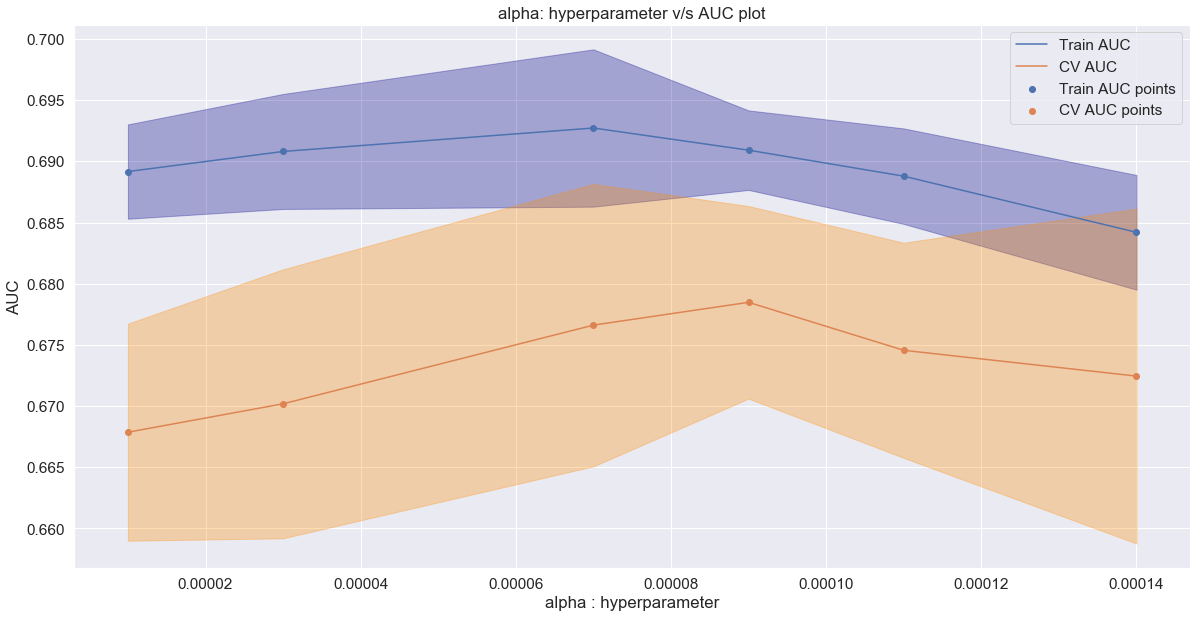

In [147]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. Values around 0.00005 to 0.00011 had almost similar AUC scores and similar Difference in Test and Cross Validation AUC scores.
2. 0.00005 was chosen by me.
3. BOTH L1 & L2 PERFORM EQUALLY GOOD ON THIS SET OF DATA

# Train the model using the best hyper parameter value (L2)

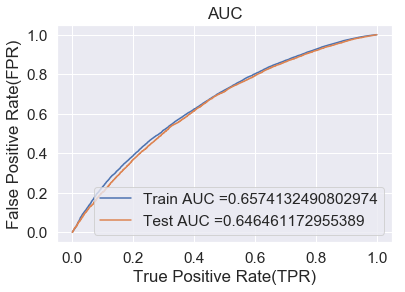

In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.005)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

Confusion Matrix (L2)

Train Data

In [149]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.998
[[ 5542  5541]
 [17407 44706]]


In [150]:
conf_matr_df_train_3_l2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.998


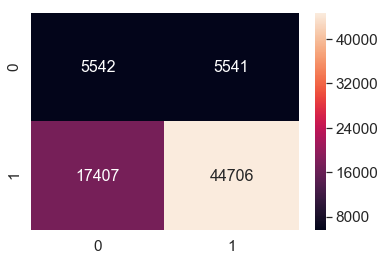

In [151]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_3_l2, annot=True,annot_kws={"size": 16}, fmt='g')

Test Data

In [152]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.014
[[ 4048  1411]
 [16846 13747]]


In [153]:
conf_matr_df_test_3_l2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.014


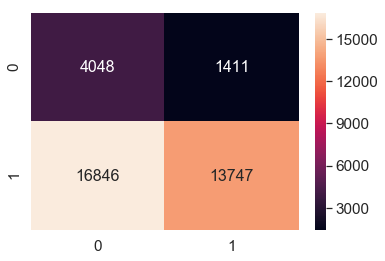

In [154]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_3_l2, annot=True,annot_kws={"size": 16}, fmt='g')

# Train the model using the best hyper parameter value (L1)

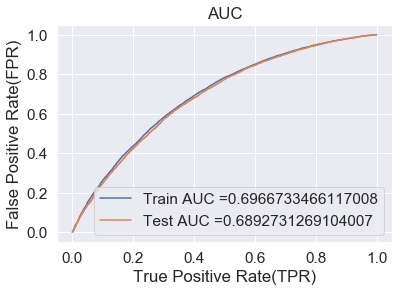

In [155]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.00005)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

# Confusion Matrix (L1)

Train Data

In [156]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 2.178
[[ 5542  5541]
 [13488 48625]]


In [157]:
conf_matr_df_train_3_l1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 2.178


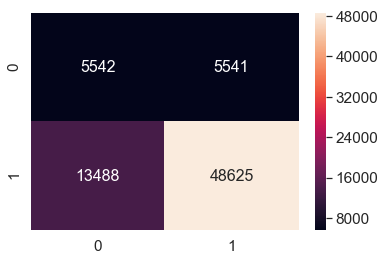

In [158]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_3_l1, annot=True,annot_kws={"size": 16}, fmt='g')

Test Data

In [159]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 3.078
[[ 4097  1362]
 [15392 15201]]


In [160]:
conf_matr_df_test_3_l1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 3.078


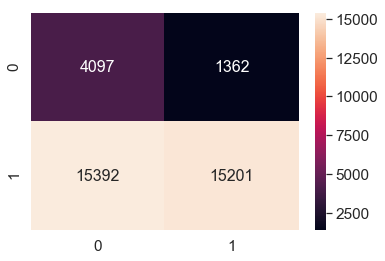

In [161]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_3_l1, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 4 : Categorical, Numerical features + Project_title(TFIDF W2V) + Preprocessed_essay (TFIDF W2V)

In [162]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_comp_train, tfidf_w2v_vectors_train, tfidf_w2v_vectors_titles_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_comp_test, tfidf_w2v_vectors_test, tfidf_w2v_vectors_titles_test)).tocsr()

In [163]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 708) (73196,)
(36052, 708) (36052,)


# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l2)

In [164]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

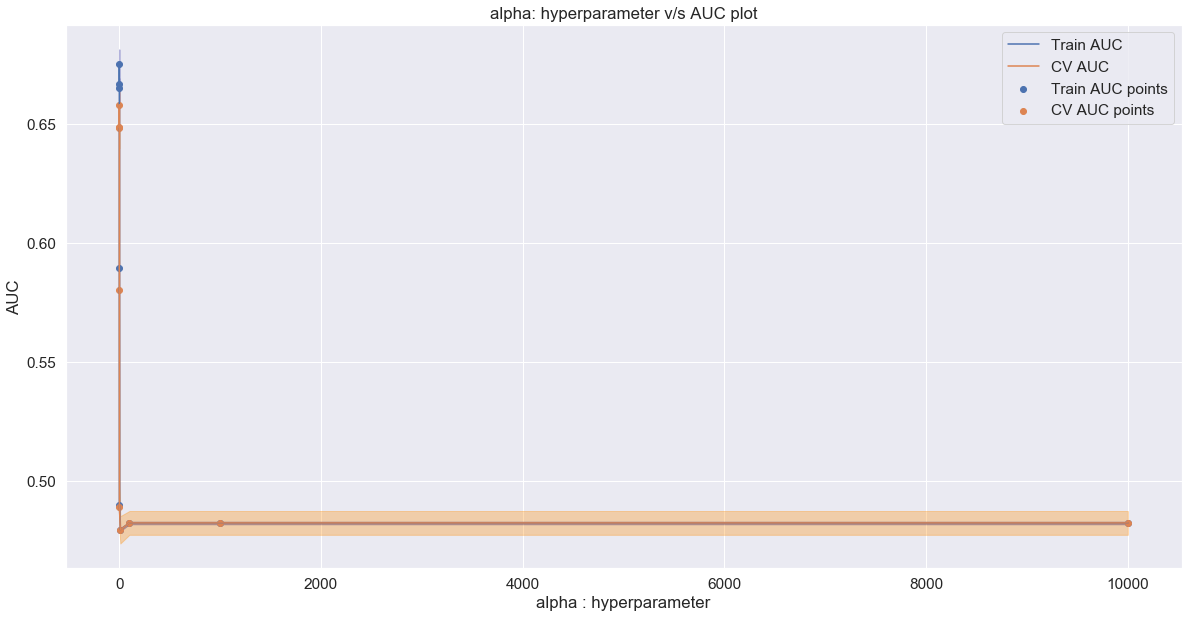

In [165]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()


Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.

In [166]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[1, 3, 4, 5, 6, 7, 8, 10]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

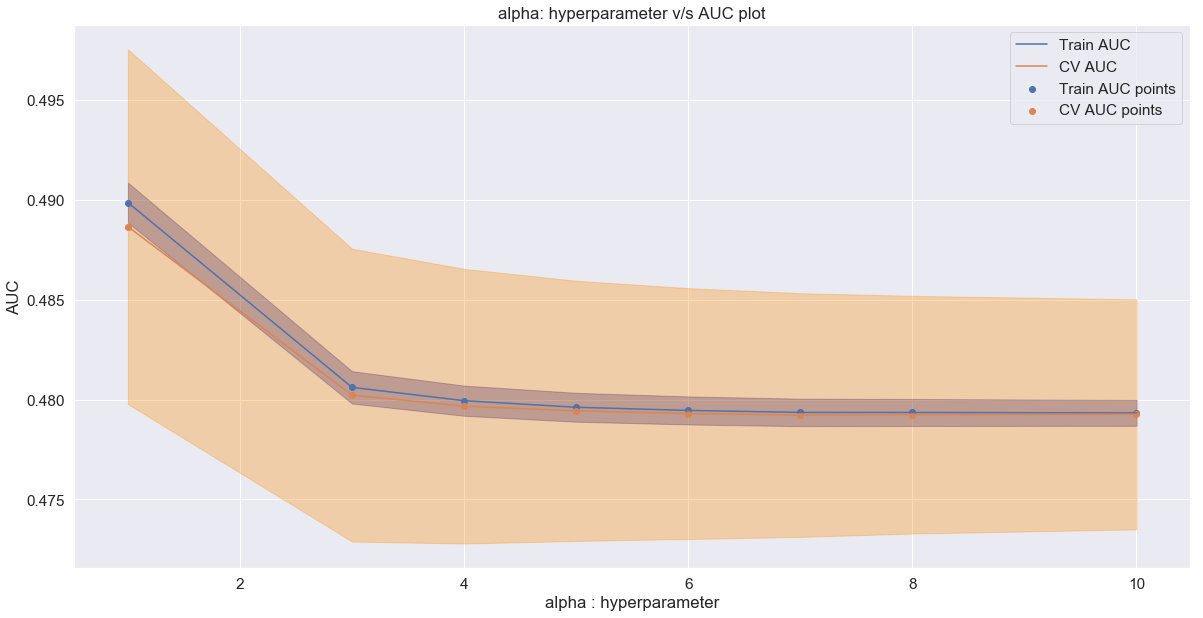

In [167]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1) Alpha value 6 seems to be a better hyperparameter value when compared to the other hyperparameters.
2) It has a better AUC score and points before and after do not have similar AUC scores.

# GridSearchCV (K fold Cross Validation) using Penalty(regularization = l1)

In [168]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

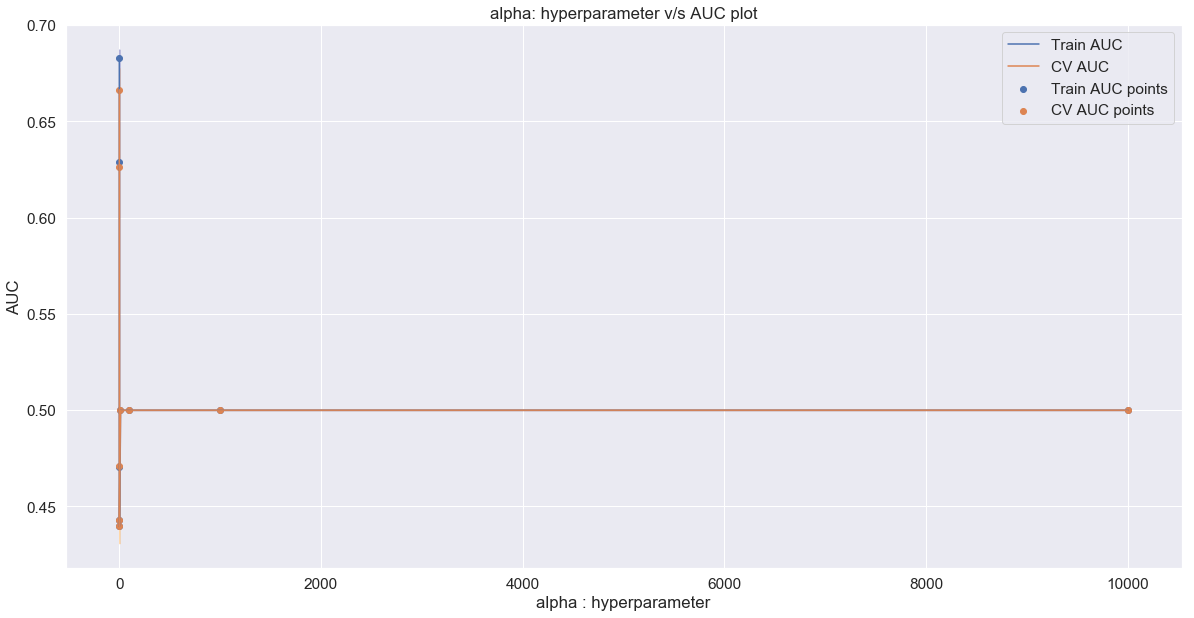

In [169]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.

In [170]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

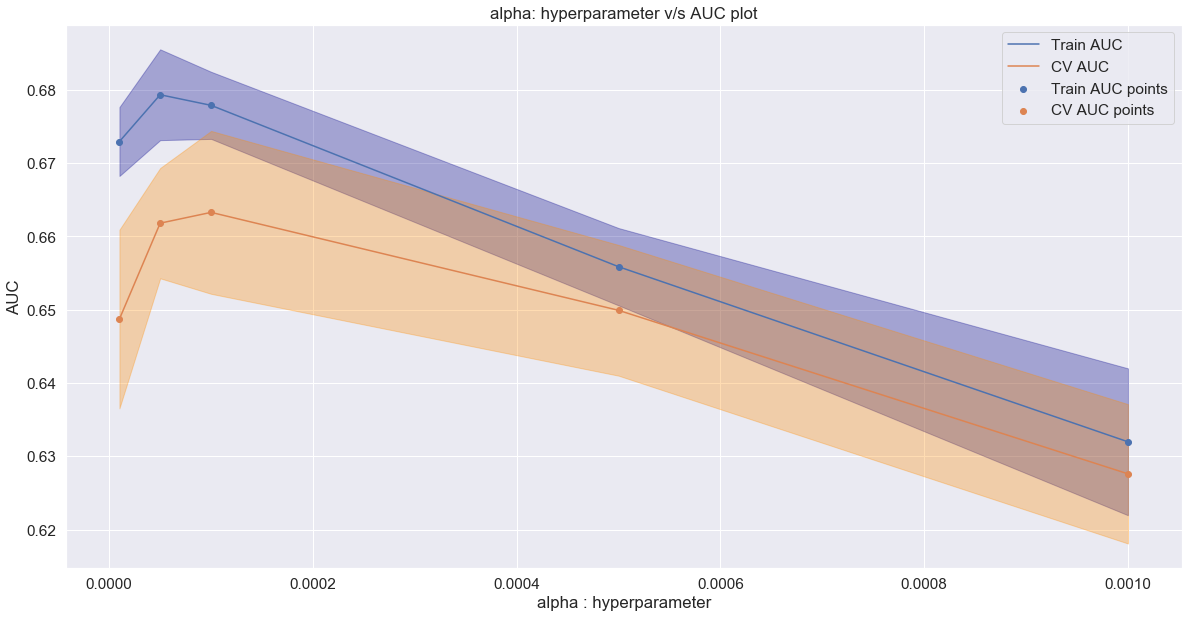

In [171]:
plt.figure(figsize=(20,10))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
0.0005 is considered as the Alpha value

# Train the model using the best hyper parameter value (L2)

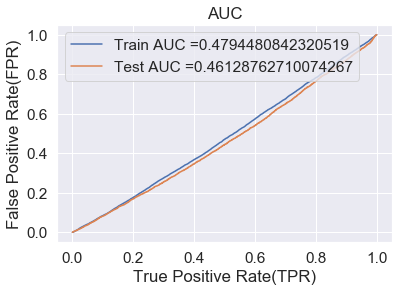

In [172]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha= 6.0)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

# Confusion Matrix (L2)

Train Data

In [173]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.028
[[ 5542  5541]
 [32900 29213]]


In [174]:
conf_matr_df_train_4_l2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.028


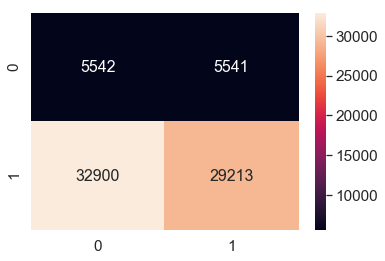

In [175]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_4_l2, annot=True,annot_kws={"size": 16}, fmt='g')

Test Data

In [176]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.073
[[ 3970  1489]
 [23496  7097]]


In [177]:
conf_matr_df_test_4_l2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.073


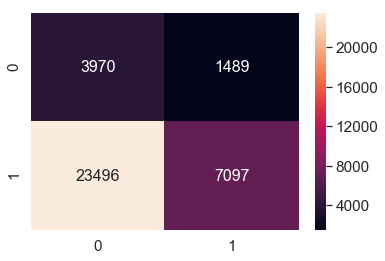

In [178]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_4_l2, annot=True,annot_kws={"size": 16}, fmt='g')

# Train the model using the best hyper parameter value (L1)

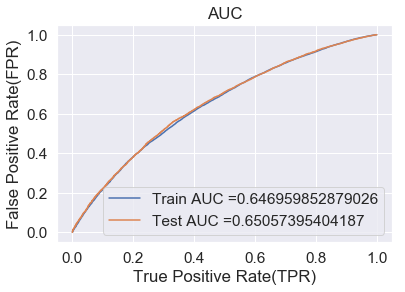

In [179]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0005)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

# Confusion Matrix (L1)

Train Data

In [180]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.99
[[ 5542  5541]
 [18401 43712]]


In [181]:
conf_matr_df_train_4_l1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.99


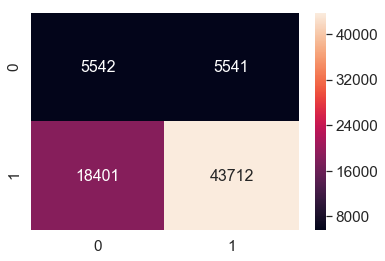

In [182]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_4_l1, annot=True,annot_kws={"size": 16}, fmt='g')

Test Data

In [183]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999244983697 for threshold 1.009
[[ 4208  1251]
 [17681 12912]]


In [184]:
conf_matr_df_test_4_l1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999244983697 for threshold 1.009


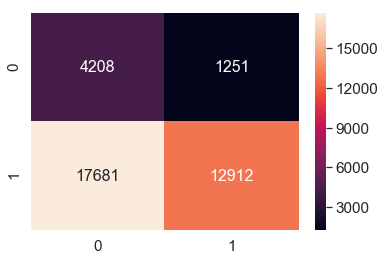

In [185]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_4_l1, annot=True,annot_kws={"size": 16}, fmt='g')

# Set 5 : Categorical features, Numerical features by TruncatedSVD on TfidfVectorizer

# A) Using Elbow method to narrow down the best number of Components

In [186]:
text_tfidf_train.shape

(73196, 132675)

In [187]:
from sklearn.decomposition import TruncatedSVD

index = [5,10,50,100,250,500,1000]
variance_sum = []

for i in tqdm(index):
    svd = TruncatedSVD(n_components= i, n_iter=7, random_state=42)
    svd.fit(text_tfidf_train)
    variance_sum.append(svd.explained_variance_ratio_.sum())

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [08:12<00:00, 115.99s/it]


In [188]:
index = [5,10,50,100,250,500,1000]

In [189]:
variance_sum

[0.005486146944981743,
 0.008790190661189273,
 0.024400663285875042,
 0.03765583906163524,
 0.0660503496714561,
 0.10016647306512982,
 0.15094518050270472]

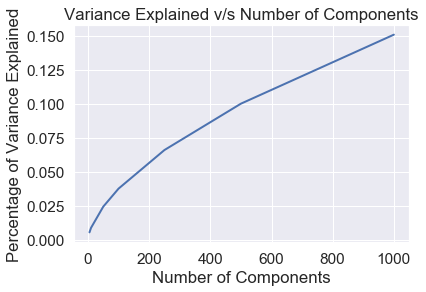

In [190]:
plt.xlabel("Number of Components")
plt.ylabel("Percentage of Variance Explained")
plt.title("Variance Explained v/s Number of Components")
plt.plot(index,variance_sum,lw=2)
plt.show()


# Train Data

In [193]:
svd = TruncatedSVD(n_components= 1000, n_iter=7, random_state=42)
svd.fit(text_tfidf_train)
svd_train = svd.transform(text_tfidf_train)

In [194]:
print("Shape of matrix after Decomposition ",svd_train.shape)

Shape of matrix after Decomposition  (73196, 1000)


# Test Data

In [195]:
svd_test = svd.transform(text_tfidf_test)
print("Shape of matrix after Decomposition ",svd_test.shape)

Shape of matrix after Decomposition  (36052, 1000)


In [197]:
from scipy.sparse import hstack

X_tr = hstack((categories_one_hot_train, sub_categories_one_hot_train, school_state_categories_one_hot_train, project_grade_categories_one_hot_train, teacher_prefix_categories_one_hot_train, price_train, quantity_train, prev_projects_train, title_word_count_train, essay_word_count_train, essay_sent_pos_train, essay_sent_neg_train, essay_sent_neu_train, essay_sent_comp_train, svd_train)).tocsr()
X_te = hstack((categories_one_hot_test, sub_categories_one_hot_test, school_state_categories_one_hot_test, project_grade_categories_one_hot_test, teacher_prefix_categories_one_hot_test, price_test, quantity_test, prev_projects_test, title_word_count_test, essay_word_count_test, essay_sent_pos_test, essay_sent_neg_test, essay_sent_neu_test, essay_sent_comp_test, svd_test)).tocsr()


In [198]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 1108) (73196,)
(36052, 1108) (36052,)


# A) GridSearchCV (K fold Cross Validation) using Penalty(regularization = l2)

In [204]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

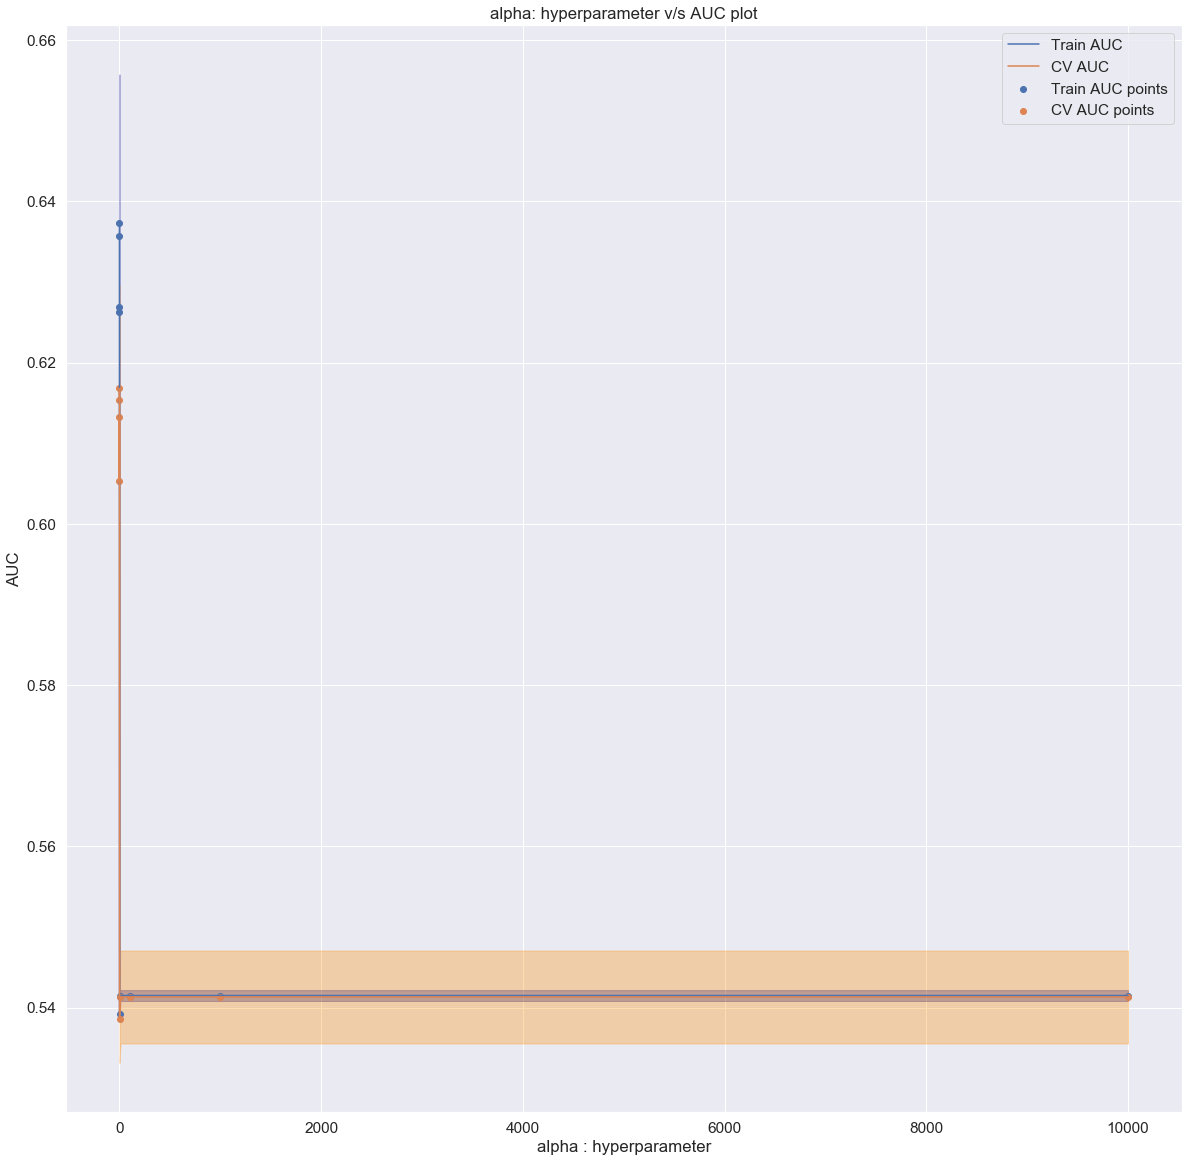

In [205]:
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()


Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.
3. Alpha values in the range of 0.1 to 1 seems to be a suitable range

In [206]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

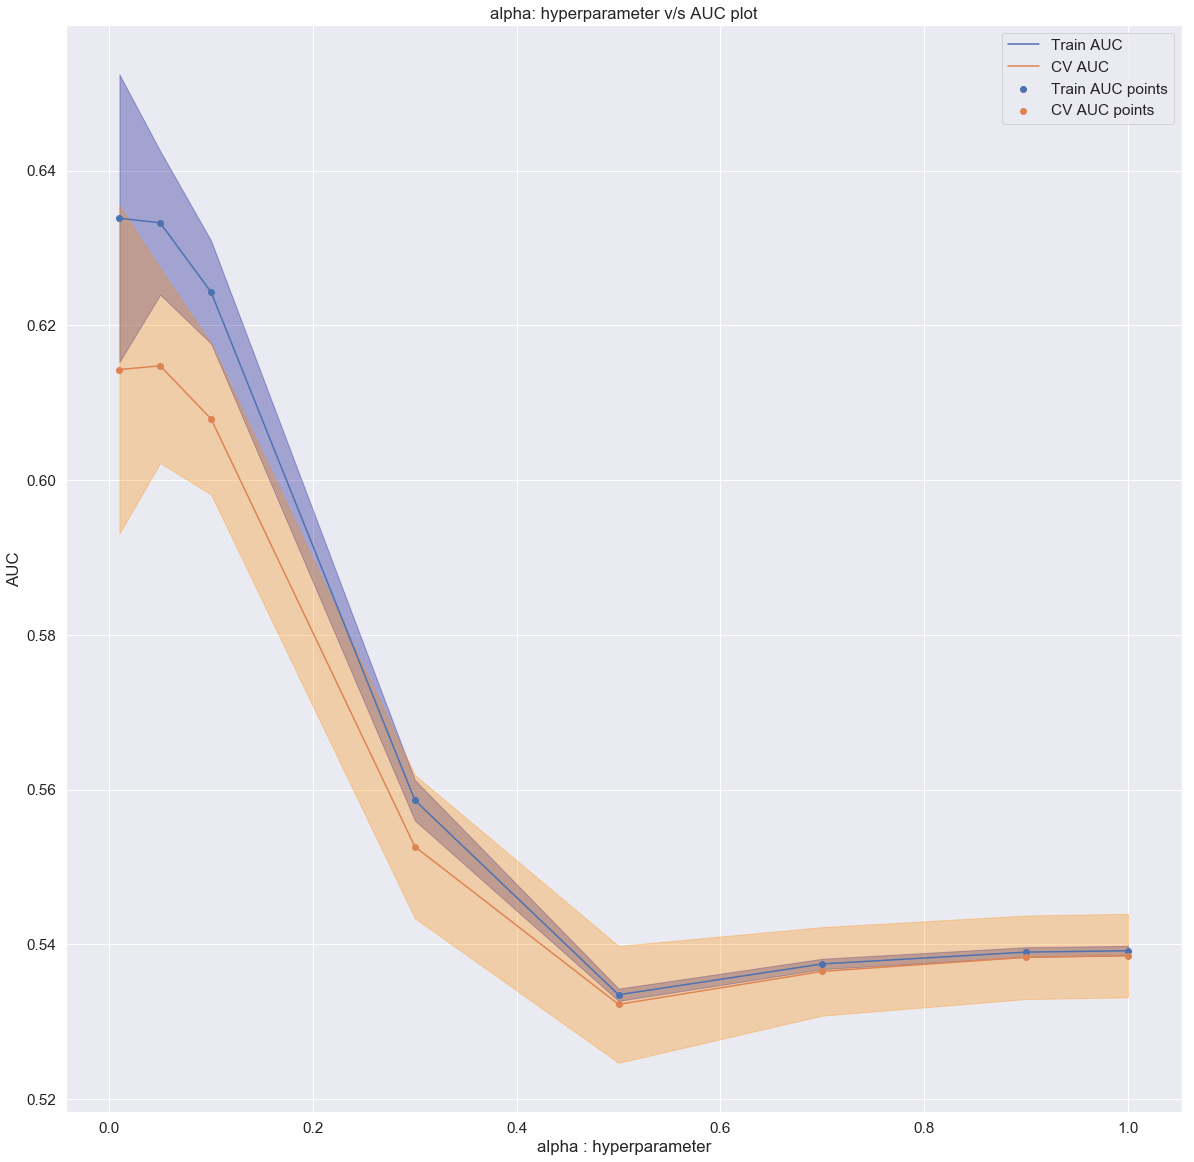

In [207]:
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference
1. I was not able to deteremine an appropriate value for my parameter. So, I have re-run the GridSearchCV on a smaller set of parameter values.
2. I was able to narrow down to a range of alpha values that might yield the expected result.
3. Alpha values in the range of 0.1 to 0.3 seems to be a suitable ran

In [208]:
sv = SGDClassifier(loss='hinge', penalty='l2')

parameters = {'alpha':[0.10, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

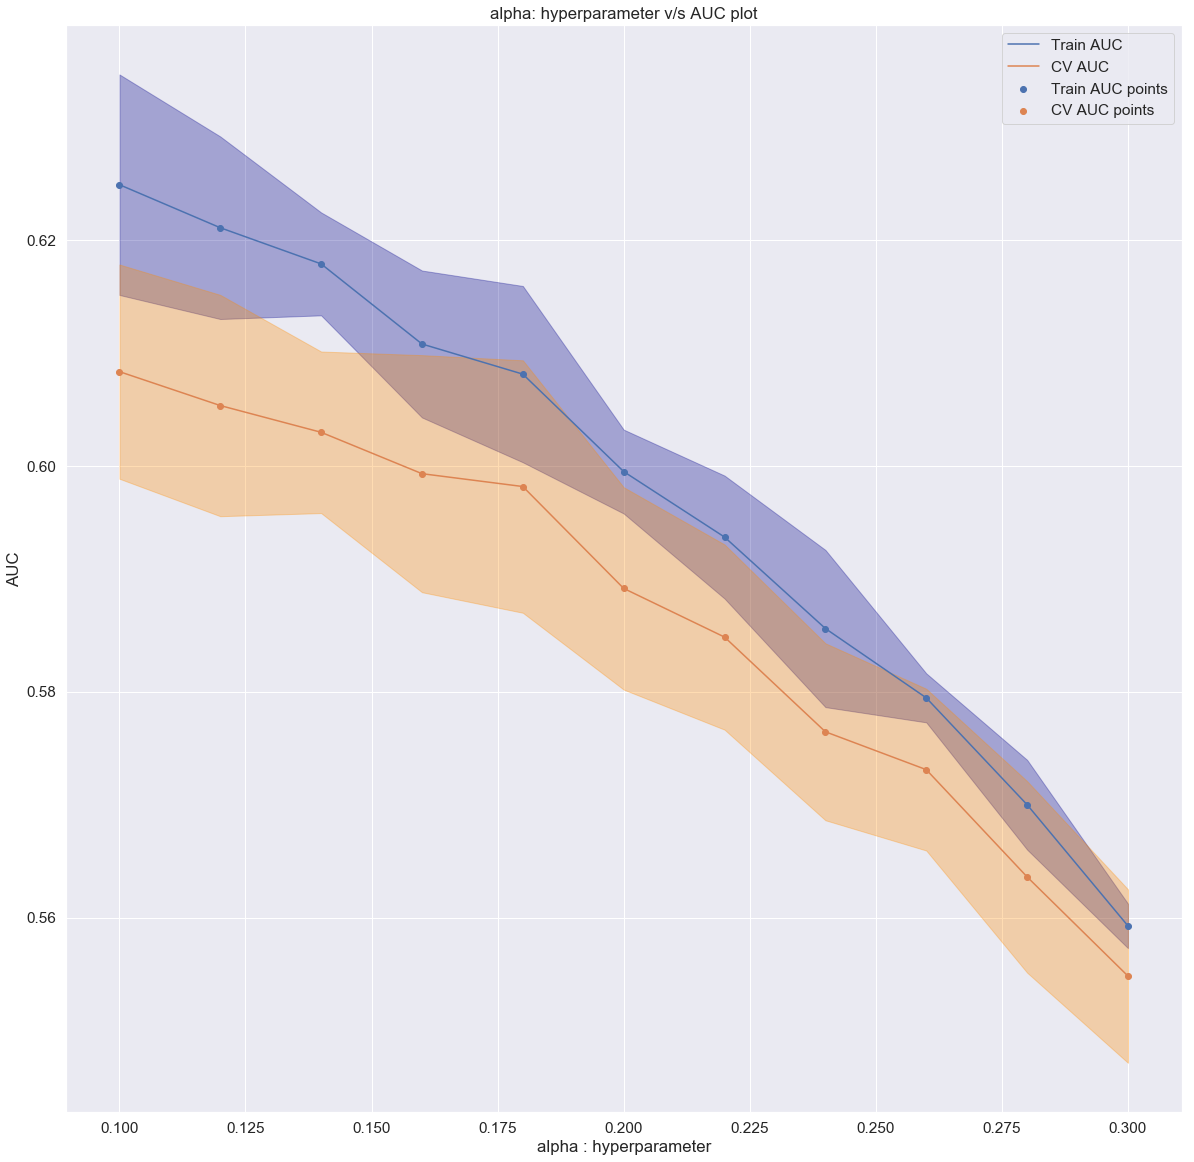

In [209]:
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

# Inference
0.18 can be considered as the alpha value.
B) GridSearchCV (K fold Cross Validation) using Penalty(regularization = l1)

In [210]:
sv = SGDClassifier(loss='hinge', penalty='l1')

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}

clf = GridSearchCV(sv, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_tr, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

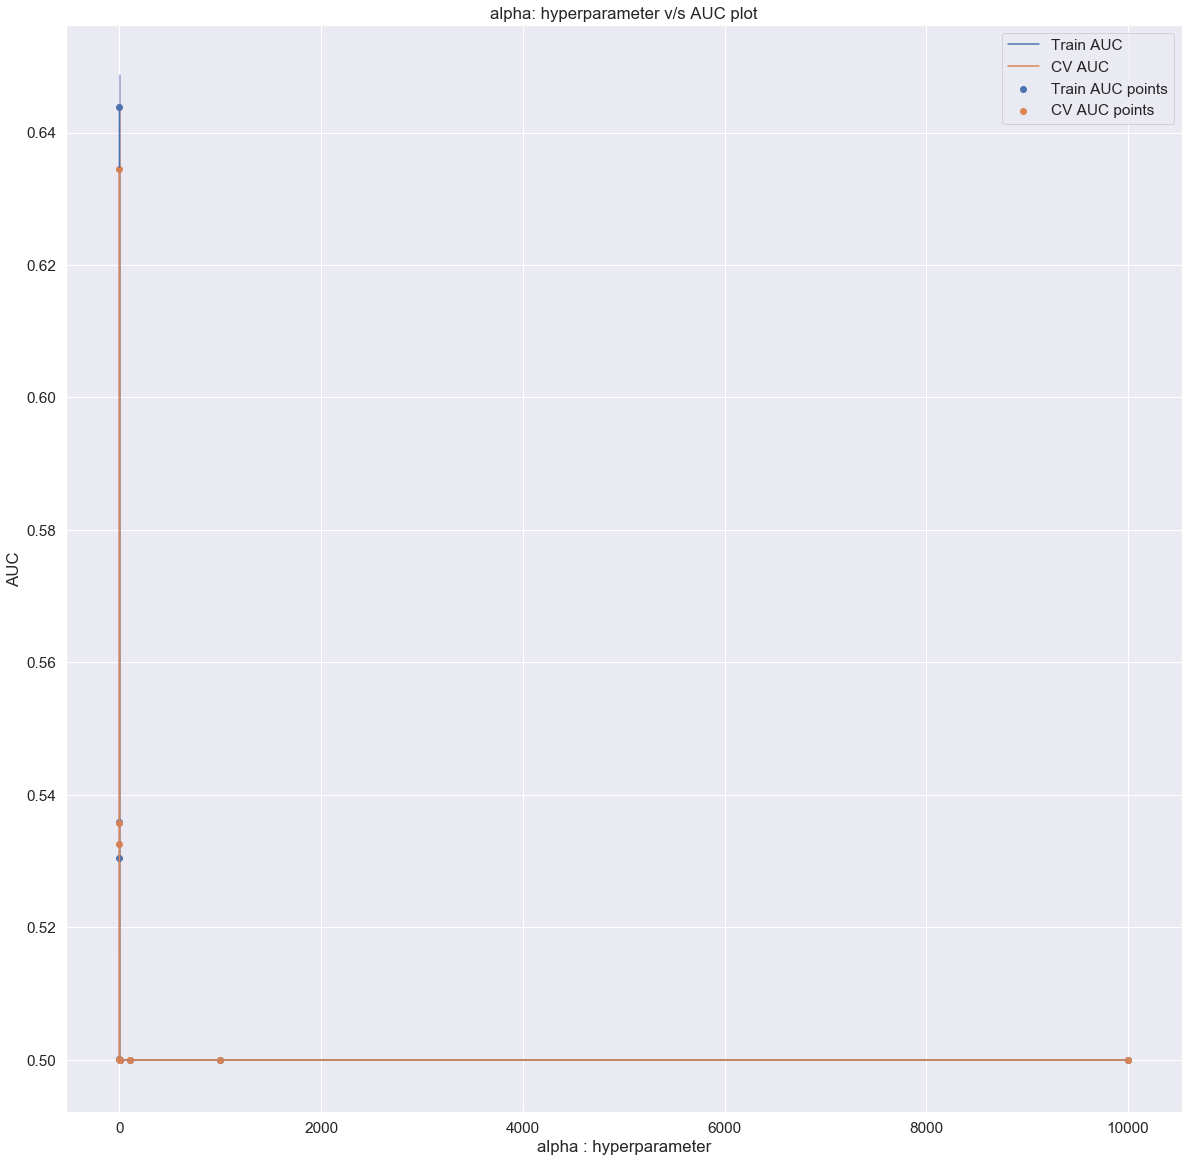

In [211]:
plt.figure(figsize=(20,20))

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC plot")
plt.show()

Inference 0.0001 can be considered as the alpha value.

# Train the model using the best hyper parameter value (L2)

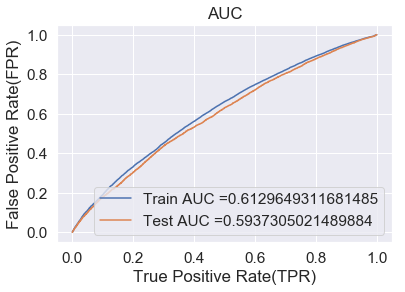

In [212]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l2', alpha= 0.18)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()


# Confusion Matrix (L2)

Train Data

In [213]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.0
[[ 5542  5541]
 [21074 41039]]


In [214]:
conf_matr_df_train_5_l2 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.0


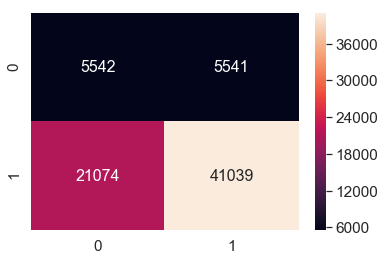

In [215]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_5_l2, annot=True,annot_kws={"size": 16}, fmt='g')

# Test data

In [216]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.001
[[ 4060  1399]
 [19009 11584]]


In [217]:
conf_matr_df_test_5_l2 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.001


# Train the model using the best hyper parameter value (L1)

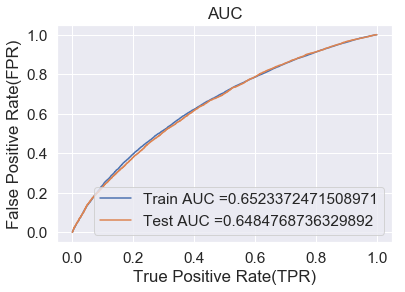

In [218]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


model = SGDClassifier(loss='hinge', penalty='l1', alpha= 0.0001)

model.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = model.decision_function(X_tr)   
y_test_pred = model.decision_function(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.show()

# Confusion Matrix (L1)

# Train Data

In [219]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.886
[[ 5542  5541]
 [18099 44014]]


In [220]:
conf_matr_df_train_5_l1 = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.886


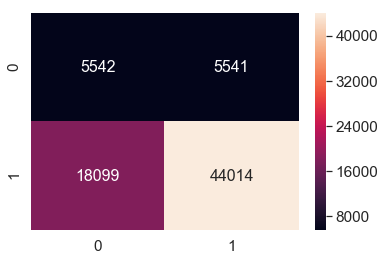

In [221]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train_5_l1, annot=True,annot_kws={"size": 16}, fmt='g')

# Test Data

In [222]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.935
[[ 4156  1303]
 [17323 13270]]


In [223]:
conf_matr_df_test_5_l1 = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.935


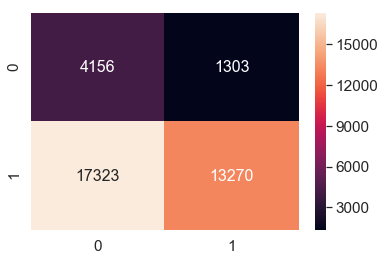

In [224]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test_5_l1, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusion

In [225]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Penalty","Alpha:Hyper Parameter", "AUC"]

x.add_row(["BOW", "Linear SVM","L2 performs better than L1", 0.3, 0.647])
x.add_row(["TFIDF", "Linear SVM", "L1 performs better than L2",0.0001, 0.667])
x.add_row(["AVG W2V", "Linear SVM", "L1 & L2 both have similar effects", "L1:0.00005 & L2:0.005", "L1:0.686 & L2:0.67"])
x.add_row(["TFIDF W2V", "Linear SVM", "Neither L1 or L2", "L1:0.0005 & L2:6.0", "L1:0.518 & L2:0.542"])
x.add_row(["TRUNCATED SVD", "Linear SVM", "L1 & L2 both have similar effects", "L1:0.0001 & L2:0.18", "L1:0.69 & L2:0.63"])


print(x)

+---------------+------------+-----------------------------------+-----------------------+---------------------+
|   Vectorizer  |   Model    |              Penalty              | Alpha:Hyper Parameter |         AUC         |
+---------------+------------+-----------------------------------+-----------------------+---------------------+
|      BOW      | Linear SVM |     L2 performs better than L1    |          0.3          |        0.647        |
|     TFIDF     | Linear SVM |     L1 performs better than L2    |         0.0001        |        0.667        |
|    AVG W2V    | Linear SVM | L1 & L2 both have similar effects | L1:0.00005 & L2:0.005 |  L1:0.686 & L2:0.67 |
|   TFIDF W2V   | Linear SVM |          Neither L1 or L2         |   L1:0.0005 & L2:6.0  | L1:0.518 & L2:0.542 |
| TRUNCATED SVD | Linear SVM | L1 & L2 both have similar effects |  L1:0.0001 & L2:0.18  |  L1:0.69 & L2:0.63  |
+---------------+------------+-----------------------------------+-----------------------+------